In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  
import matplotlib
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
## key frames
# all_data: has multiple rows per cell (cell_id x CNV)
# merged_cell_data: 1 row per cell, extra rows for truncal cells (with signatures estimated from all clonal mutaitons or per cell)
# merged_cell_data2: includes merged_cell_data, also  mean_median_mrca_burden,cell_trunk_df,merged_normal_cells, through concatenation
#           when concatenating, adding relevant entries to data_type column, so we can distinguish if a data point corresponds to a cell or other summary entities

In [3]:
## required files

# metadata
    # metadata: for translating between different sample name conventions, eg BTE1 vs BT36
    # snames_df: previous cell annotation
    # annotated_cell_list: scNanoSeq_metadata_v5.csv: used to create a normal cell list, tumor cell list and remnant cells

# mutation data
    # all_data: power corrected mutational burden per cell
    # trunk_data_bulk: power corrected mutational burdens per cell, only including mutations that overlap with the bulk deep WGS
    # cell_clonal_cnv_footprint: total footprint of CNV regions, stratified by total copy number
    # trunk_data: power corrected mutational burdens per cell, only including truncal mutations, as categorized by CellPhy

# others
    # bulkcov_stats: evaluating the proportion of mutations that are not included, per cell, because the coverage of matched normal sample is too low. This varies from sample to sample

# signature exposures
    # new_sc_exp_df: exposures per cell
    # new_trunk_exp_fn: truncal exposures per sample
    # normal_merged_exp_df: combined exposures for normal cells

In [4]:
tree_dist_fn = '/home/dg204/projects/brca_timing/data/processed/trees_n21/allDistances_Feb25.csv'

In [5]:
genome_size_mb=2800

In [6]:
# sample_name metadata
metadata_fn='/home/dg204/park_dglodzik/scNanoSeq_Dominik//00_metadata/sample_ID_mapping.txt'
snames_df = pd.read_csv(metadata_fn, sep='\t')
metadata = pd.read_csv('/n/data1/hms/dbmi/park/michail_a/scData/sample_ID_mapping_dg_annot_tumor_cells.txt', sep=',')
metadata = metadata[['Sample_ID_internal', 'Truncal.node', 'no_tumor_cells', 'tumor_cells']]
metadata['tumor_highdepth_path'] = '/home/dg204/park_dglodzik/scNanoSeq_Dominik/08_Ultima_ultradeep_tumor_bulk/tumor_mutation/z100_' + metadata['Sample_ID_internal'] + '.lofreq.clean.vcf'
metadata_m = pd.merge(metadata, snames_df, left_on='Sample_ID_internal', right_on='Sample_ID_internal')
metadata_m.head(1)
cancer_cells = []
for index, row in metadata_m.iterrows():
    cancer_cells = cancer_cells + row['tumor_cells'].split(';')

sample_id_dict = snames_df.set_index('Sample_ID_internal')['Sample_ID_ms'].to_dict()

annotated_cell_list = pd.read_csv('/home/dg204/projects/brca_timing/data/processed/trees_n21/scNanoSeq_metadata_v5.csv')
normal_curated_cells = []
for index, row in annotated_cell_list.iterrows():
    if pd.notna(row['non_tumor_cells_curated_standardized']):
        normal_curated_cells += row['non_tumor_cells_curated_standardized'].split(',')
transformed_cancer_cells = []
for index, row in annotated_cell_list.iterrows():
    transformed_cancer_cells  += row['tumor_cells'].split(',')

remnant_cells = []
for index, row in annotated_cell_list.iterrows():
    if not pd.isna(row['remnant_cells']):
        remnant_cells += str(row['remnant_cells']).split(',')

normal_curated_cells = [sample_id_dict[cell.split('_')[0]] + '_' + cell.split('_')[1] for cell in normal_curated_cells]
transformed_cancer_cells = [sample_id_dict[cell.split('_')[0]] + '_' + cell.split('_')[1] for cell in transformed_cancer_cells]
remnant_cells = [sample_id_dict[cell.split('_')[0]] + '_' + cell.split('_')[1] for cell in remnant_cells]


In [7]:
# where are the BT20_sc005 [BTH4] or BT6_sc033 [BTT4] cells

In [8]:
snames_df.head(1)

,Sample_ID_ms,Sample_ID_internal
0,BTE1,BT36


In [9]:
metadata_m.head(1)

,Sample_ID_internal,Truncal.node,no_tumor_cells,tumor_cells,tumor_highdepth_path,Sample_ID_ms
0,BT36,29,18,BT36_sc024;BT36_sc010;BT36_sc004;BT36_sc020;BT...,/home/dg204/park_dglodzik/scNanoSeq_Dominik/08...,BTE1


In [10]:
def compileCellBurdens(resultPath):
    file_paths = glob.glob(resultPath + 'CN*_regions_corr_power_output/*_power_corrected_results.csv')

    # Add file path as a new column in each dataframe
    
    # Load all tables into a list of dataframes
    dataframes = [pd.read_csv(file) for file in file_paths]
    
    for i, df in enumerate(dataframes):
        df['file_path'] = file_paths[i]
        
    # Optionally, you can concatenate all dataframes into a single dataframe
    all_data = pd.concat(dataframes, ignore_index=True)
    all_data['file_path'][0]
    all_data['CN'] = all_data['file_path'].str.extract(r'CN(\d+)_')
    all_data['sample_name'] = all_data['cell_name'].str.extract(r'([^_]+)_')

    mut_burden_df = all_data['mut_burden_per_multiplicity'].apply(lambda x: pd.Series([int(i) for i in x.strip('[]').split()]))
    # Rename the new columns
    mut_burden_df.columns = [f'mut_burden_{i+1}' for i in mut_burden_df.columns]

    power_df = all_data['analytical_power_g'].apply(lambda x: pd.Series([float(i) for i in x.strip('[ ]').split()]))
    # Rename the new columns
    power_df.columns = [f'power_df_{i+1}' for i in power_df.columns]

    mut_count_df = pd.Series(all_data['mut_count'].apply(lambda x: pd.Series([int(i) for i in x.strip('[]').split(',')])).sum(axis=1))
    mut_count_df.name='detected_muts'

    power_burden = pd.Series((mut_burden_df * power_df.values).sum(axis=1))
    power_burden.name = 'power_burden_product_sum'

    # Concatenate the new columns with the original dataframe
    all_data = pd.concat([all_data, mut_burden_df, mut_count_df, power_burden], axis=1)
    all_data['total_burden'] = mut_burden_df.sum(axis=1, skipna=True)

    # rows in this data frame correspond to cell/CN 

    return all_data

In [11]:
all_data = compileCellBurdens('/n/data1/hms/dbmi/park/michail_a/scData2/scNanoSeq_gnomAD_PowerCorrectedMutBurdens/')
# calculate cell G
cell_clonal_cnv_footprint = pd.read_csv('/home/dg204/projects/brca_timing/data/processed/cellCnvClonalList_v2.csv', index_col=0)
trunk_data_bulk = compileCellBurdens('/home/dg204/projects/brca_timing/data/external/Michael/scNanoSeq_TRUNK_Ultradeep_v2_power_corrected_burdens/')
# ploidy across all cells
all_data['CN'] = all_data['CN'].astype(float)
all_data = pd.merge(all_data, cell_clonal_cnv_footprint, left_on=['cell_name', 'CN'], right_on=['cellID', 'cnv'], how='left' )
# rows are cells/copy number states
all_data.to_csv('/home/dg204/projects/brca_timing/data/processed/scNanoseq/all_burdens.csv', index=False)

# scNanoSeq data, only the truncal mutations
trunk_data = compileCellBurdens('/home/dg204/projects/brca_timing/data/external/Michael/scNanoSeq_TRUNK_power_corrected_burdens/')

trunk_data_bulk.head(1)

,cell_name,mut_count,length_in_CN[Mb],d,analytical_power_g,mut_burden_per_multiplicity,res_norm,file_path,CN,sample_name,mut_burden_1,mut_burden_2,mut_burden_3,mut_burden_4,detected_muts,power_burden_product_sum,total_burden
0,BTE4_sc001,[0],189.021036,0.447134,[0.0189626],[0],0.0,/home/dg204/projects/brca_timing/data/external...,1,BTE4,0.0,NaN,NaN,NaN,0.0,0.0,0.0


In [12]:
mut_count_df = pd.read_csv('/home/dg204/projects/brca_timing/data/external/Michael/mutation_counts_per_cell.csv').iloc[:,[0,2]]
mut_count_df.columns = ['cell_name', 'raw_mutation_count']
mut_count_df.head(1)

,cell_name,raw_mutation_count
0,BTE1_sc001,161


In [13]:
# calculate cell-counted ploidy
cell_ploidy = (
    all_data
    .groupby('cell_name')
    .apply(lambda group: (group['CN'] * group['length_in_CN[Mb]']).sum() / group['length_in_CN[Mb]'].sum())
    .reset_index(name='weighted_avg_CN')
)

cell_ploidy['sample'] = cell_ploidy['cell_name'].str[:4]
cell_ploidy['isTumor'] = cell_ploidy['cell_name'].isin(transformed_cancer_cells)
sample_ploidy = cell_ploidy[cell_ploidy['isTumor']==True].groupby('sample').agg({'weighted_avg_CN': 'median'}).reset_index()
cell_ploidy.head(1)


,cell_name,weighted_avg_CN,sample,isTumor
0,BTE1_sc001,3.43353,BTE1,True


In [14]:

all_data['m_over_T_sum'] = (all_data['mut_burden_1'].fillna(0)  + all_data['mut_burden_2'].fillna(0) * 2 + all_data['mut_burden_3'].fillna(0) * 3 + all_data['mut_burden_4'].fillna(0) * 4) / all_data['CN']
all_data['mult_sum'] = (all_data['mut_burden_1'].fillna(0)  + all_data['mut_burden_2'].fillna(0) * 2 + all_data['mut_burden_3'].fillna(0) * 3 + all_data['mut_burden_4'].fillna(0) * 4)

trunk_data['mult_sum_trunk'] = (trunk_data['mut_burden_1'].fillna(0)  + trunk_data['mut_burden_2'].fillna(0) * 2 + trunk_data['mut_burden_3'].fillna(0) * 3 + trunk_data['mut_burden_4'].fillna(0) * 4)
trunk_data['m_over_T_sum_trunk'] = trunk_data['mult_sum_trunk'] / trunk_data['CN'].astype(float)


trunk_data_bulk['mult_sum_trunk_bulk'] = (trunk_data_bulk['mut_burden_1'].fillna(0)  + trunk_data_bulk['mut_burden_2'].fillna(0) * 2 + trunk_data_bulk['mut_burden_3'].fillna(0) * 3 + trunk_data_bulk['mut_burden_4'].fillna(0) * 4)
trunk_data_bulk['m_over_T_sum_trunk_bulk'] = trunk_data_bulk['mult_sum_trunk_bulk'] / trunk_data_bulk['CN'].astype(float)

aggregated_all_data = all_data.groupby('cell_name').agg({'m_over_T_sum': 'sum', 
                                                         'length_in_CN[Mb]' : 'sum',
                                                         'total_burden': 'sum',
                                                         'mult_sum': 'sum',
                                                         'footprint_bp' : 'sum',
                                                         'detected_muts' : 'sum',
                                                         'power_burden_product_sum' : 'sum'}).reset_index()

aggregated_cell_trunk_burden = trunk_data.groupby('cell_name').agg({
                                                             'total_burden': 'sum',
                                                             'mult_sum_trunk': 'sum',
                                                             'm_over_T_sum_trunk' : 'sum',
                                                             'detected_muts' : 'sum',
                                                             'power_burden_product_sum' : 'sum'                                                          
                                                             }).reset_index()
aggregated_cell_trunk_burden.columns = ['cell_name','trunk_total_burden', 'mult_sum_trunk', 'm_over_T_sum_trunk', 'detected_muts_trunk', 'power_burden_product_sum_trunk']

aggregated_cell_trunk_bulk_burden = trunk_data_bulk.groupby('cell_name').agg({
                                                             'total_burden': 'sum',
                                                             'mult_sum_trunk_bulk': 'sum',
                                                             'm_over_T_sum_trunk_bulk' : 'sum',
                                                             'detected_muts' : 'sum',
                                                            'power_burden_product_sum' : 'sum'
                                                             }).reset_index()
aggregated_cell_trunk_bulk_burden.columns = ['cell_name','trunk_bulk_total_burden', 'mult_sum_trunk_bulk', 'm_over_T_sum_trunk_bulk', 'detected_muts_trunk_bulk', 'power_burden_product_sum_trunk_bulk']

# rows in this data correspond to cells
merged_cell_data = aggregated_all_data
#merged_cell_data = pd.merge(merged_cell_data, aggregated_cell_trunk_burden, how='left')
merged_cell_data = pd.merge(merged_cell_data, aggregated_cell_trunk_burden, how='left')
merged_cell_data = pd.merge(merged_cell_data, aggregated_cell_trunk_bulk_burden, how='left')
merged_cell_data = pd.merge(merged_cell_data, mut_count_df,  how='left') # there is a problem here for BTE3
merged_cell_data = pd.merge(merged_cell_data, cell_ploidy[['cell_name','weighted_avg_CN']], how='left')
merged_cell_data['G'] = merged_cell_data['total_burden'] / merged_cell_data['m_over_T_sum'] 
merged_cell_data['mult_avg']= merged_cell_data['mult_sum']/merged_cell_data['total_burden'] # multiplicity
merged_cell_data['mult_avg_trunk_bulk']= merged_cell_data['mult_sum_trunk_bulk']/merged_cell_data['trunk_bulk_total_burden'] # multiplicity
merged_cell_data['burden_diploid'] = 2 * merged_cell_data['m_over_T_sum'] * genome_size_mb / merged_cell_data['length_in_CN[Mb]']
merged_cell_data['mult_trunk_avg']= merged_cell_data['mult_sum_trunk']/merged_cell_data['trunk_total_burden']
merged_cell_data['burden_trunk_diploid'] =2 * merged_cell_data['m_over_T_sum_trunk'] * genome_size_mb / merged_cell_data['length_in_CN[Mb]']
merged_cell_data['burden_trunk_bulk_diploid'] = 2 *merged_cell_data['m_over_T_sum_trunk_bulk'] * genome_size_mb / (merged_cell_data['footprint_bp']/1e6)
#see compareBurdensOldNew.ipynb
#merged_cell_data.to_csv('../../data/processed/cell_burdens_new.csv')

# the logic is that if a cell is in the transformed_list, it willl be considered a tumor cell, and normal otherwise
merged_cell_data['isTumor'] = merged_cell_data['cell_name'].isin(transformed_cancer_cells)
merged_cell_data['sample_id'] = merged_cell_data['cell_name'].str.split('_').str[0]
merged_cell_data['sample_id_TN'] = merged_cell_data['sample_id'] + '_' + merged_cell_data['isTumor'].map({True: 'T', False : 'N'})

BULKCOV_stats_fn = '/home/dg204/projects/brca_timing/data/external/Michael/BULKCOV_stats_per_cell.csv'
bulkcov_stats = pd.read_csv(BULKCOV_stats_fn)

aggregated_cell_footprint = all_data.groupby('cell_name').agg({'length_in_CN[Mb]': 'sum'}).reset_index()
merged_cell_data = pd.merge(merged_cell_data, aggregated_cell_footprint)
merged_cell_data = pd.merge(merged_cell_data, bulkcov_stats, left_on = 'cell_name', right_on='cell', how='left')


# correct by percentage of discarded mutations (because of germline coverage) and total copy number
# this is the column that has the total mutational burden
merged_cell_data['total_burden_corr'] =  merged_cell_data['total_burden'] *  (1 / (1-merged_cell_data['perc_of_disc_muts'])) * 3000 / merged_cell_data['length_in_CN[Mb]'] 
merged_cell_data['total_trunk_burden_corr'] =  merged_cell_data['trunk_total_burden'] *  (1 / (1-merged_cell_data['perc_of_disc_muts'])) * 3000 / merged_cell_data['length_in_CN[Mb]'] 
merged_cell_data['trunk_bulk_total_burden_corr'] =  merged_cell_data['trunk_bulk_total_burden'] *  (1 / (1-merged_cell_data['perc_of_disc_muts'])) * 3000 / (merged_cell_data['footprint_bp']/1e6) 
# rescale to diploid genome
merged_cell_data['total_burden_corr_G'] =  merged_cell_data['total_burden'] *  (1 / (1-merged_cell_data['perc_of_disc_muts'])) * 2 * 3000 / merged_cell_data['length_in_CN[Mb]'] / merged_cell_data['G']
merged_cell_data['burden_diploid_corr'] = merged_cell_data['burden_diploid'] * (1 / (1-merged_cell_data['perc_of_disc_muts']))
merged_cell_data['burden_trunk_diploid_corr'] = merged_cell_data['burden_trunk_diploid'] * (1 / (1-merged_cell_data['perc_of_disc_muts']))
merged_cell_data['burden_trunk_bulk_diploid_corr'] = merged_cell_data['burden_trunk_bulk_diploid'] * (1 / (1-merged_cell_data['perc_of_disc_muts']))

merged_cell_data['cell_power_exp'] = merged_cell_data['power_burden_product_sum'] / merged_cell_data['total_burden']
merged_cell_data['trunk_bulk_power_exp'] = merged_cell_data['power_burden_product_sum_trunk_bulk'] / merged_cell_data['trunk_bulk_total_burden']

In [15]:
merged_cell_data['sample_id'].value_counts().sort_index()

BTE1    20
BTE2    21
BTE3    83
BTE4    49
BTE5    17
BTE6    20
BTE7    18
BTH1    23
BTH3    18
BTH4    61
BTH5    12
BTH6    22
BTH7    14
BTT1    77
BTT2    16
BTT3    57
BTT4    92
BTT5    47
BTT6    48
BTT7    66
Name: sample_id, dtype: int64

In [16]:
merged_cell_data['sample_id'].value_counts().shape

(20,)

In [17]:
# from the the treeLengths notebook
# extrapolate the MRCA burden by combining the estimated total burden with d_MRCA from the tree
mrca_df = pd.read_csv(tree_dist_fn, index_col=0)
merged_cell_data_mrca_prop = pd.merge(merged_cell_data,
                                 mrca_df,
                                 left_on='cell_name', 
                                 right_on='ms_cell_name')
merged_cell_data_mrca_prop['mrca_burden'] = merged_cell_data_mrca_prop['total_burden_corr'] * merged_cell_data_mrca_prop['d_mrca']

# estimating the MRCA mutational burden
mean_mrca_burden_per_sample = merged_cell_data_mrca_prop[merged_cell_data_mrca_prop['isTumor']==True].groupby('sample_id')['mrca_burden'].mean()
median_mrca_burden_per_sample = merged_cell_data_mrca_prop[merged_cell_data_mrca_prop['isTumor']==True].groupby('sample_id')['mrca_burden'].median()
median_mrca_prop = merged_cell_data_mrca_prop[merged_cell_data_mrca_prop['isTumor']==True].groupby('sample_id')['d_mrca'].median()


mean_median_mrca_burden = pd.DataFrame({
    'mean_mrca_burden': mean_mrca_burden_per_sample,
    'median_mrca_burden': median_mrca_burden_per_sample,
    'median_mrca_prop' : median_mrca_prop
})

mean_median_mrca_burden['sample_id'] = mean_median_mrca_burden.index
mean_median_mrca_burden['total_burden_corr'] = mean_median_mrca_burden['mean_mrca_burden']
mean_median_mrca_burden['data_type'] = 'trunk_tree'
mean_median_mrca_burden['cell_name'] = mean_median_mrca_burden['sample_id'] + '_trunk'
mean_median_mrca_burden
mean_median_mrca_burden.to_csv('/home/dg204/projects/brca_timing/data/processed/trees_n21/mean_median_mrca_burden_Feb25.csv')

merged_cell_data.head(1)

,cell_name,m_over_T_sum,length_in_CN[Mb],total_burden,mult_sum,footprint_bp,detected_muts,power_burden_product_sum,trunk_total_burden,mult_sum_trunk,m_over_T_sum_trunk,detected_muts_trunk,power_burden_product_sum_trunk,trunk_bulk_total_burden,mult_sum_trunk_bulk,m_over_T_sum_trunk_bulk,detected_muts_trunk_bulk,power_burden_product_sum_trunk_bulk,raw_mutation_count,weighted_avg_CN,G,mult_avg,mult_avg_trunk_bulk,burden_diploid,mult_trunk_avg,burden_trunk_diploid,burden_trunk_bulk_diploid,isTumor,sample_id,sample_id_TN,cell,no_total_unf_mutations,no_discarded_mutations_BULKCOV20,perc_of_disc_muts,total_burden_corr,total_trunk_burden_corr,trunk_bulk_total_burden_corr,total_burden_corr_G,burden_diploid_corr,burden_trunk_diploid_corr,burden_trunk_bulk_diploid_corr,cell_power_exp,trunk_bulk_power_exp
0,BTE1_sc001,2284.75,2807.553722,6354.0,7946.0,1.539041e+09,132.0,131.979528,1924.0,2435.0,629.25,42.0,41.973726,2383.0,3094.0,902.25,51.0,50.988761,161.0,3.43353,2.781048,1.250551,1.298363,4557.205762,1.265593,1255.114006,3282.953316,True,BTE1,BTE1_T,BTE1_sc001,187,11,0.058824,7213.886894,2184.374942,4935.418959,5187.890488,4842.031122,1333.558632,3488.137898,0.020771,0.021397


In [18]:
# per cell truncal exposures
cell_trunk_df = merged_cell_data[merged_cell_data['isTumor']==True][['cell_name','sample_id','burden_trunk_bulk_diploid_corr']].copy()
cell_trunk_df.columns = ['cell_name', 'sample_id','burden_diploid_corr']
cell_trunk_df['data_type'] = 'trunk_cell'
cell_trunk_df['cell_name'] = cell_trunk_df['cell_name'] + '_trunk'
cell_trunk_df.index = cell_trunk_df['cell_name']


In [19]:
cell_trunk_df.head()

,cell_name,sample_id,burden_diploid_corr,data_type
cell_name,,,,
BTE1_sc001_trunk,BTE1_sc001_trunk,BTE1,3488.137898,trunk_cell
BTE1_sc002_trunk,BTE1_sc002_trunk,BTE1,2869.065948,trunk_cell
BTE1_sc004_trunk,BTE1_sc004_trunk,BTE1,3219.306201,trunk_cell
BTE1_sc005_trunk,BTE1_sc005_trunk,BTE1,2816.288019,trunk_cell
BTE1_sc008_trunk,BTE1_sc008_trunk,BTE1,3048.191418,trunk_cell


In [20]:
# these are dummies - to merge SBS1 exposures
merged_normal_cells = pd.DataFrame({'sample_id' : snames_df['Sample_ID_ms']})
merged_normal_cells['data_type'] = 'normal_merged'
merged_normal_cells['cell_name'] = merged_normal_cells['sample_id'] + '_normal_merged'
merged_normal_cells.index = merged_normal_cells['cell_name']
merged_normal_cells.head()

,sample_id,data_type,cell_name
cell_name,,,
BTE1_normal_merged,BTE1,normal_merged,BTE1_normal_merged
BTE2_normal_merged,BTE2,normal_merged,BTE2_normal_merged
BTE3_normal_merged,BTE3,normal_merged,BTE3_normal_merged
BTE4_normal_merged,BTE4,normal_merged,BTE4_normal_merged
BTE5_normal_merged,BTE5,normal_merged,BTE5_normal_merged


In [21]:
# add per cell data to trunk data

merged_cell_data['data_type'] = merged_cell_data['isTumor'].map({True: 'scTumor', False: 'scNormal'})
merged_cell_data.loc[merged_cell_data['cell_name'].isin(remnant_cells), 'data_type'] = 'other'

# add the trunk data to the cell-level data
merged_cell_data2 = pd.concat([merged_cell_data, 
                               mean_median_mrca_burden,
                               cell_trunk_df,
                               merged_normal_cells], axis=0)

# Change the order of data_type
custom_order = ['scNormal', 'normal_merged','trunk_tree', 'trunk_cell', 'scTumor', 'other']

merged_cell_data2['data_type'] = pd.Categorical(
    merged_cell_data2['data_type'], 
    categories=custom_order, 
    ordered=True
)
merged_cell_data2.head(1)

,cell_name,m_over_T_sum,length_in_CN[Mb],total_burden,mult_sum,footprint_bp,detected_muts,power_burden_product_sum,trunk_total_burden,mult_sum_trunk,m_over_T_sum_trunk,detected_muts_trunk,power_burden_product_sum_trunk,trunk_bulk_total_burden,mult_sum_trunk_bulk,m_over_T_sum_trunk_bulk,detected_muts_trunk_bulk,power_burden_product_sum_trunk_bulk,raw_mutation_count,weighted_avg_CN,G,mult_avg,mult_avg_trunk_bulk,burden_diploid,mult_trunk_avg,burden_trunk_diploid,burden_trunk_bulk_diploid,isTumor,sample_id,sample_id_TN,cell,no_total_unf_mutations,no_discarded_mutations_BULKCOV20,perc_of_disc_muts,total_burden_corr,total_trunk_burden_corr,trunk_bulk_total_burden_corr,total_burden_corr_G,burden_diploid_corr,burden_trunk_diploid_corr,burden_trunk_bulk_diploid_corr,cell_power_exp,trunk_bulk_power_exp,data_type,mean_mrca_burden,median_mrca_burden,median_mrca_prop
0,BTE1_sc001,2284.75,2807.553722,6354.0,7946.0,1.539041e+09,132.0,131.979528,1924.0,2435.0,629.25,42.0,41.973726,2383.0,3094.0,902.25,51.0,50.988761,161.0,3.43353,2.781048,1.250551,1.298363,4557.205762,1.265593,1255.114006,3282.953316,True,BTE1,BTE1_T,BTE1_sc001,187.0,11.0,0.058824,7213.886894,2184.374942,4935.418959,5187.890488,4842.031122,1333.558632,3488.137898,0.020771,0.021397,scTumor,NaN,NaN,NaN


In [22]:
merged_cell_data['data_type'].value_counts()

scTumor     585
scNormal    187
other         9
Name: data_type, dtype: int64

In [23]:
# signatures: 
# all mutations per cell
new_sc_exp_fn = '/home/dg204/projects/brca_timing/data/external/Michael/scNanoseq_sigs/250212/scNanoSeq_perCell_BasicSigsSet_Feb25_v3.csv'
new_sc_exp_df = pd.read_csv(new_sc_exp_fn, index_col=0)
#new_sc_exp_df = new_sc_exp_df.div(new_sc_exp_df.sum(axis=0), axis=1)
new_sc_exp_df.index.name = 'signature'

# Normalize all_exposure_data by dividing by column sum
normalized_exposure_data = new_sc_exp_df.div(new_sc_exp_df.sum(axis=0), axis=1)
normalized_exposure_data_T = normalized_exposure_data.T
normalized_exposure_data_T['sample_id'] = normalized_exposure_data_T.index.str.replace('_.*', '')
normalized_exposure_data_T['data_type'] = 'sc_total'
normalized_exposure_data_T.head(1)

# signatures: truncal mutations per sample
new_trunk_exp_fn = '/home/dg204/projects/brca_timing/data/external/Michael/scNanoseq_sigs/250212/scNanoSeq_perSample_trunk_exposures_v3.csv'
new_trunk_exp_df = pd.read_csv(new_trunk_exp_fn, index_col=0)
new_trunk_exp_df.index.name = 'signature'
#new_trunk_exp_df = new_trunk_exp_df.reset_index()

truncal_exposures_per_sample_norm_T = new_trunk_exp_df.div(new_trunk_exp_df.sum(axis=0), axis=1).T
truncal_exposures_per_sample_norm_T.index = truncal_exposures_per_sample_norm_T.index.str.replace('_tunk', '_trunk')
truncal_exposures_per_sample_norm_T['data_type'] = 'sample_trunk'
truncal_exposures_per_sample_norm_T['sample_id'] = truncal_exposures_per_sample_norm_T.index.str.split('_trunk').str[0]

# for each "trunk" tumor cell, look up SBS1 exposure of the trunk
cell_trunk_sigs = truncal_exposures_per_sample_norm_T.loc[cell_trunk_df['sample_id']+'_trunk',][['SBS1', 'SBS3']]
cell_trunk_sigs.index= cell_trunk_df.index

normal_merged_exp_fn = '/home/dg204/projects/brca_timing/data/external/Michael/H_Grouped_Normal_Cells_v4.csv'
normal_merged_exp_df = pd.read_csv(normal_merged_exp_fn, index_col=0).T
normal_merged_exp_df = normal_merged_exp_df.div(normal_merged_exp_df.sum(axis=1), axis=0)
normal_merged_exp_df.index = normal_merged_exp_df.index + '_normal_merged'
normal_merged_exp_df.index.name = ''

normalized_exposure_data_T_with_trunk = pd.concat([normalized_exposure_data_T,  truncal_exposures_per_sample_norm_T, cell_trunk_sigs, normal_merged_exp_df], axis=0)

merged_cell_data2['cell_name_std'] = merged_cell_data2['cell_name'].str.replace(
    r'_sc(\d+)',
    lambda m: f"_sc{int(m.group(1)):03d}",
    regex=True
)

merged_cell_data2_sigs = pd.merge(merged_cell_data2, normalized_exposure_data_T_with_trunk, left_on='cell_name_std', right_index=True, how='left')


normal_merged_exp_df['sample_id'] = [s[:4] for s in normal_merged_exp_df.index]
# this column will use the 'merged_normal' exposures for the normal cells
merged_cell_data2_sigs['SBS1_merged_normal'] = merged_cell_data2_sigs['sample_id_x'].map(normal_merged_exp_df.set_index('sample_id')['SBS1'])
rows_to_leave = (merged_cell_data2_sigs['isTumor']==True) | (merged_cell_data2_sigs['cell_name'].str.contains('_trunk'))  | (merged_cell_data2_sigs['cell_name'].str.contains('_normal_merged'))
merged_cell_data2_sigs.loc[rows_to_leave, 'SBS1_merged_normal'] = merged_cell_data2_sigs.loc[rows_to_leave,'SBS1']


merged_cell_data2_sigs['total_burden_SBS1'] = merged_cell_data2_sigs['total_burden_corr'] * merged_cell_data2_sigs['SBS1']
merged_cell_data2_sigs['total_burden_SBS3'] = merged_cell_data2_sigs['total_burden_corr'] * merged_cell_data2_sigs['SBS3']
merged_cell_data2_sigs['burden_diploid_corr_SBS1'] = merged_cell_data2_sigs['burden_diploid_corr'] * merged_cell_data2_sigs['SBS1']
merged_cell_data2_sigs['burden_diploid_corr_SBS1_merged_normal'] = merged_cell_data2_sigs['burden_diploid_corr'] * merged_cell_data2_sigs['SBS1_merged_normal']

merged_cell_data2_sigs.to_csv('~/projects/brca_timing/data/processed/scNanoseq/scNanoseq_burdens_with_signatures_Feb25.csv')

/tmp/ipykernel_53747/1187620554.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  normalized_exposure_data_T['sample_id'] = normalized_exposure_data_T.index.str.replace('_.*', '')


In [24]:
# for debugging
#normalized_exposure_data_T[normalized_exposure_data_T.index.str.startswith("BTE3")]

In [25]:
###############################
# plots

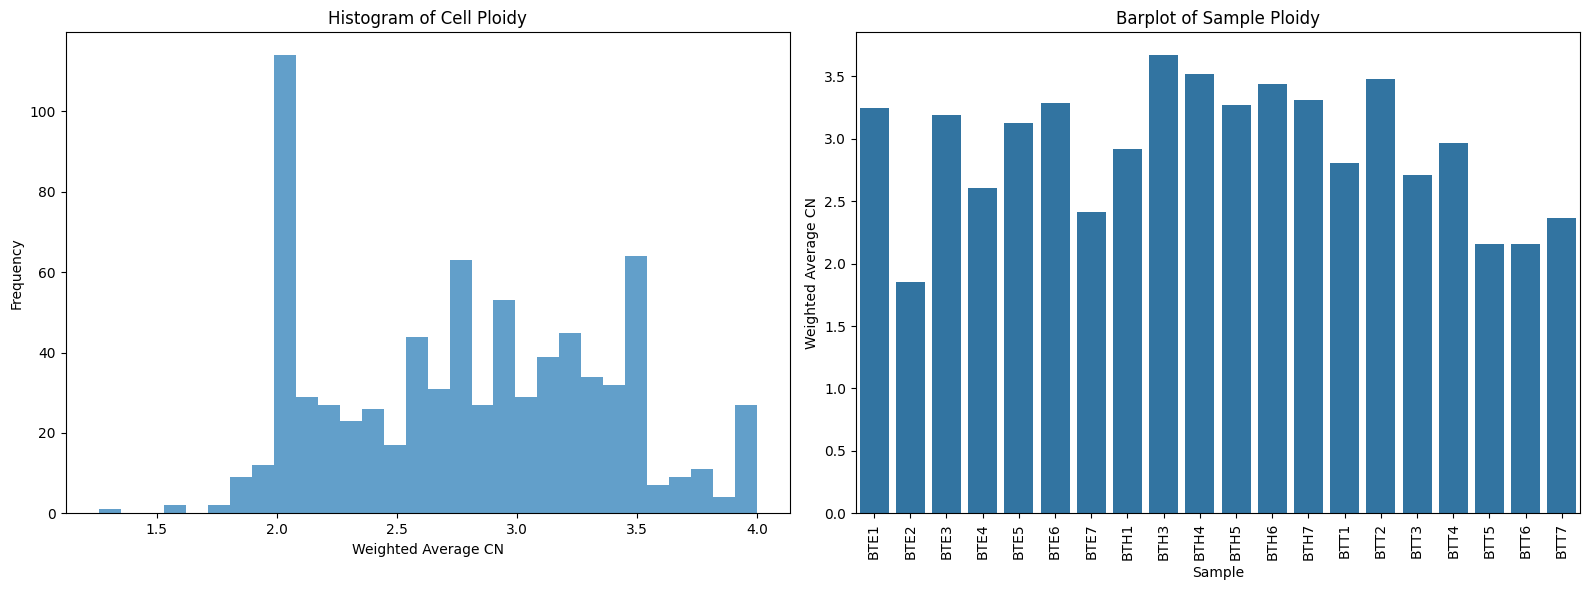

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

# Plot histogram of cell ploidy
cell_ploidy['weighted_avg_CN'].plot.hist(ax=ax[0], bins=30, alpha=0.7)
ax[0].set_title('Histogram of Cell Ploidy')
ax[0].set_xlabel('Weighted Average CN')
ax[0].set_ylabel('Frequency')

# Plot barplot of sample ploidy
sns.barplot(x='sample', y='weighted_avg_CN', data=sample_ploidy, ax=ax[1])
ax[1].set_title('Barplot of Sample Ploidy')
ax[1].set_xlabel('Sample')
ax[1].set_ylabel('Weighted Average CN')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'average mutation multiplicity (all mutations) per cell')

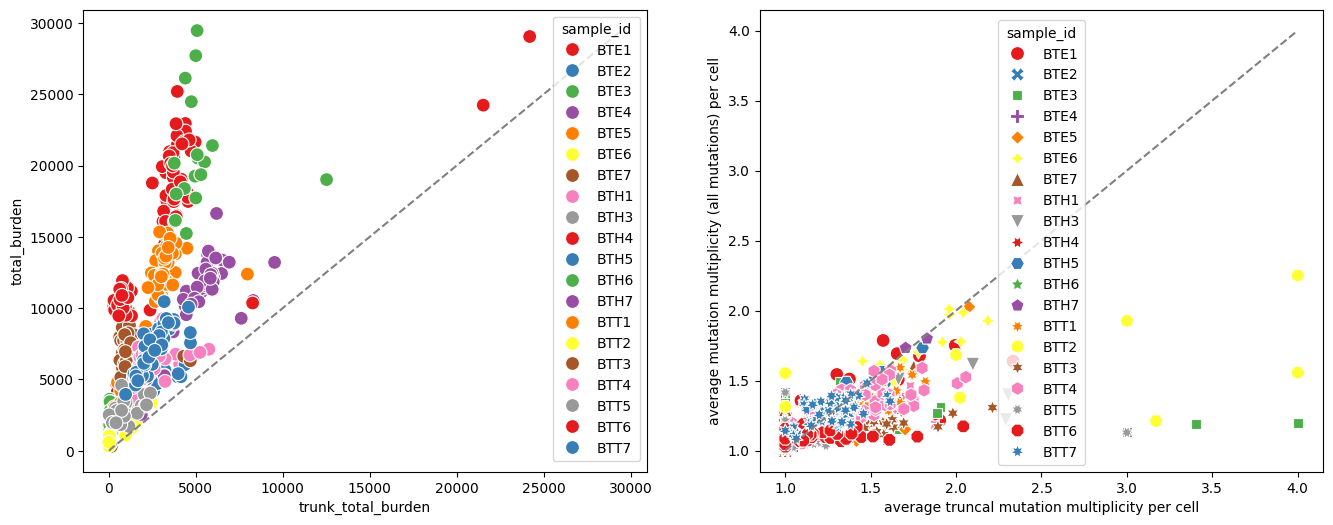

In [27]:
plot_data = merged_cell_data[merged_cell_data['isTumor']==True]

fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

# First plot
sns.scatterplot(
    data=plot_data, 
    x='trunk_total_burden', 
    y='total_burden', 
    hue='sample_id', 
    palette='Set1', 
    s=100,  # Adjust marker size
    ax=axes[0]
)

min_val = min(plot_data['trunk_total_burden'].min(), plot_data['total_burden'].min())
max_val = max(plot_data['trunk_total_burden'].max(), plot_data['total_burden'].max())
axes[0].plot([min_val, max_val], [min_val, max_val], linestyle="--", color="gray", label="y = x")

# Second plot
sns.scatterplot(
    data=plot_data, 
    x='mult_trunk_avg', 
    y='mult_avg', 
    hue='sample_id', 
    style='sample_id',
    palette='Set1', 
    s=100,  # Adjust marker size
    ax=axes[1]
)

min_val = min(plot_data['mult_trunk_avg'].min(), plot_data['mult_avg'].min())
max_val = max(plot_data['mult_trunk_avg'].max(), plot_data['mult_avg'].max())
axes[1].plot([min_val, max_val], [min_val, max_val], linestyle="--", color="gray", label="y = x")
axes[1].set_xlabel('average truncal mutation multiplicity per cell')
axes[1].set_ylabel('average mutation multiplicity (all mutations) per cell')


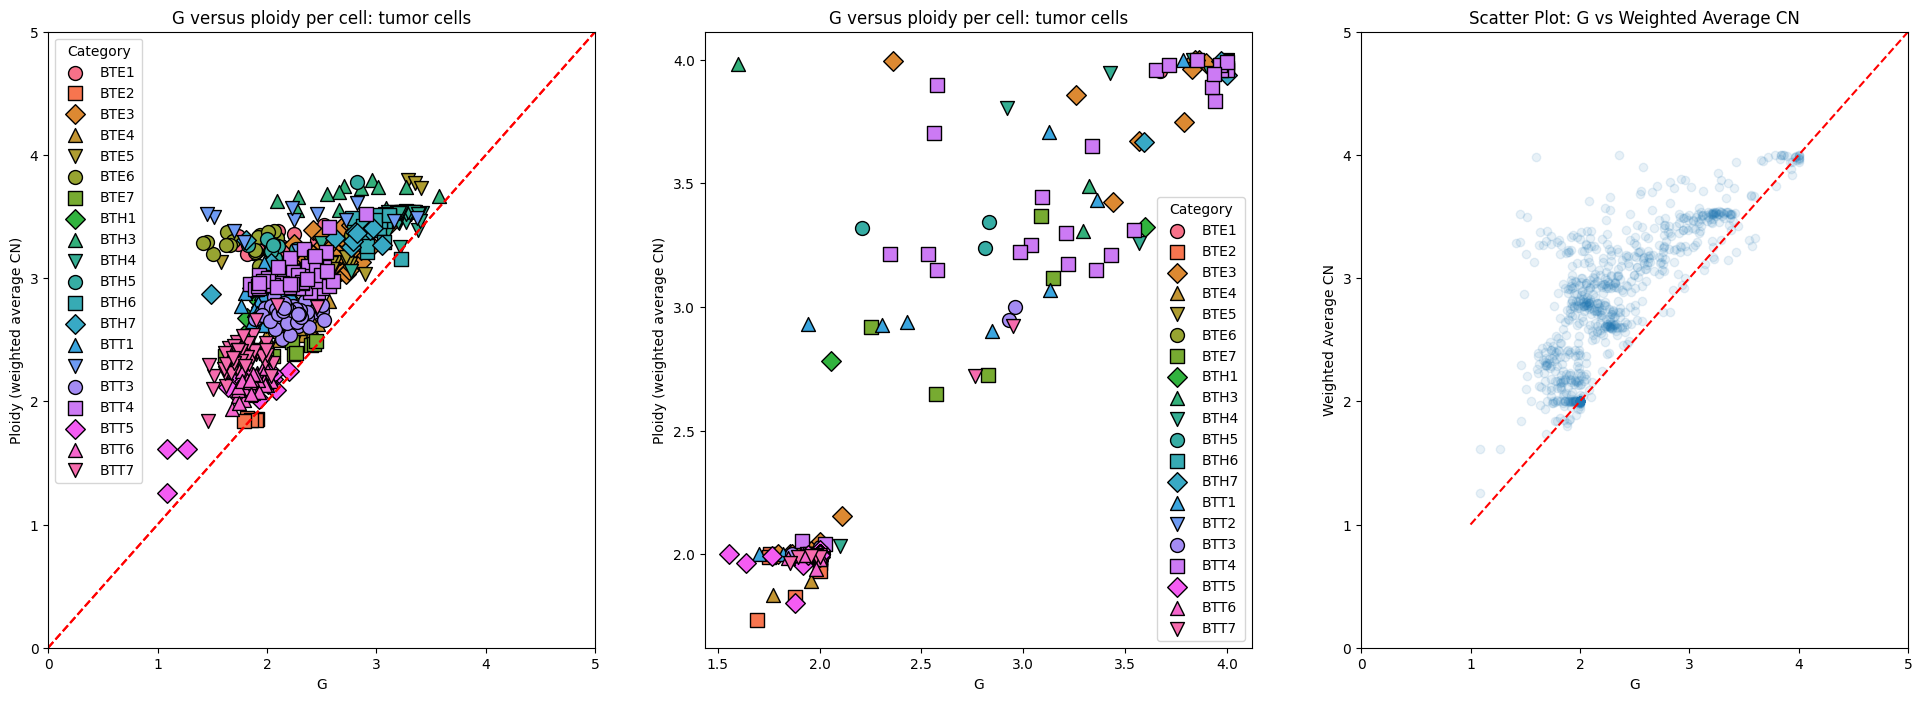

In [28]:
markers = ['o', 's', 'D', '^', 'v']  # Define different marker styles
palette = sns.color_palette("husl", len(merged_cell_data['sample_id'].unique()))  # Assign unique colors

# Create the scatter plot with a larger figure size
fig, axes = plt.subplots(ncols=3, figsize=(24, 8))  # Adjust width for better spacing


# Plot each category separately
for i, (category, group) in enumerate(merged_cell_data[merged_cell_data['isTumor']==True].groupby('sample_id')):
    axes[0].scatter(group['G'], group['weighted_avg_CN'], 
            label=category, 
            color=palette[i], 
            marker=markers[i % len(markers)], 
            edgecolors='black', 
            s=100)  # Adjust size if needed

    group_n = merged_cell_data[(merged_cell_data['isTumor']==False) & (merged_cell_data['sample_id']==category)]
    axes[1].scatter(group_n['G'], group_n['weighted_avg_CN'], 
            label=category, 
            color=palette[i], 
            marker=markers[i % len(markers)], 
            edgecolors='black', 
            s=100)  # Adjust size if needed


# Formatting
axes[0].set_xlabel("G")
axes[0].set_ylabel("Ploidy (weighted average CN)")
axes[0].set_title('G versus ploidy per cell: tumor cells')
axes[0].legend(title="Category")

# Add a diagonal line
axes[0].plot([0, 5], [0, 5], 'r--')
axes[0].set_xlim(0, 5)
axes[0].set_ylim(0, 5)

axes[1].set_xlabel("G")
axes[1].set_ylabel("Ploidy (weighted average CN)")
axes[1].set_title('G versus ploidy per cell: tumor cells')
axes[1].legend(title="Category")

# Add a diagonal line
axes[0].plot([0, 5], [0, 5], 'r--')
axes[0].set_xlim(0, 5)
axes[0].set_ylim(0, 5)


axes[2].scatter(merged_cell_data['G'], merged_cell_data['weighted_avg_CN'], alpha=0.1)#, edgecolor='k')
axes[2].set_xlim([0,5])
axes[2].set_ylim([0,5])
axes[2].plot([1, 5], [1, 5], color='red', linestyle='--', label='y = x')

# Add labels and title
axes[2].set_xlabel('G')
axes[2].set_ylabel('Weighted Average CN')
axes[2].set_title('Scatter Plot: G vs Weighted Average CN')
plt.show()

<Figure size 2400x800 with 0 Axes>

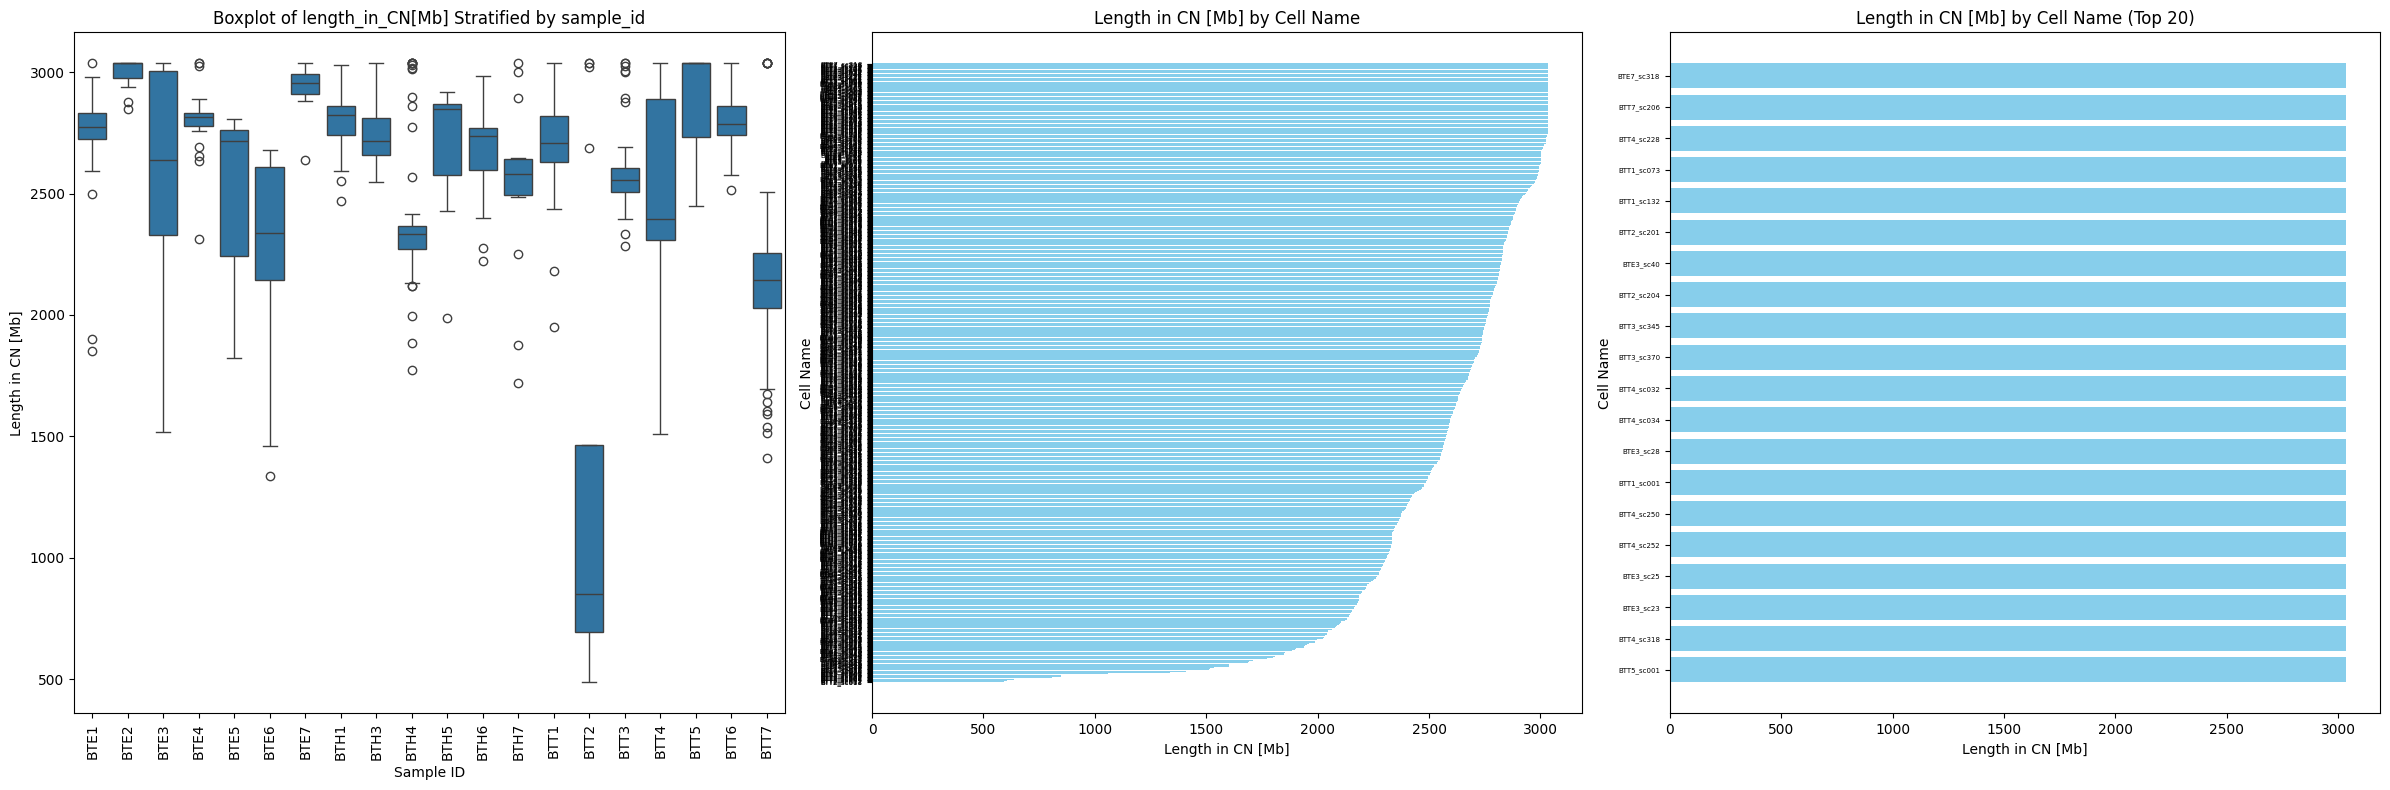

In [29]:
plt.figure(figsize=(24, 8))  # Adjust width for better spacing

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(ncols=3, figsize=(24, 8))

# First plot: Boxplot of length_in_CN[Mb] Stratified by sample_id
sns.boxplot(data=merged_cell_data, x='sample_id', y='length_in_CN[Mb]', ax=axes[0])
axes[0].set_title('Boxplot of length_in_CN[Mb] Stratified by sample_id')
axes[0].set_xlabel('Sample ID')
axes[0].set_ylabel('Length in CN [Mb]')
axes[0].tick_params(axis='x', rotation=90)

# Sort the data by 'length_in_CN[Mb]' in descending order
sorted_data = merged_cell_data.sort_values(by='length_in_CN[Mb]', ascending=False)

# Second plot: Bar plot of length_in_CN[Mb] by Cell Name (all cells)
axes[1].barh(sorted_data['cell_name'], sorted_data['length_in_CN[Mb]'], color='skyblue')
axes[1].set_xlabel('Length in CN [Mb]')
axes[1].set_ylabel('Cell Name')
axes[1].set_title('Length in CN [Mb] by Cell Name')
axes[1].invert_yaxis()  # Invert y-axis to have the highest values at the top
axes[1].tick_params(axis='y', labelsize=5)

# Third plot: Bar plot of length_in_CN[Mb] by Cell Name (top 20 cells)
axes[2].barh(sorted_data['cell_name'].head(20), sorted_data['length_in_CN[Mb]'].head(20), color='skyblue')
axes[2].set_xlabel('Length in CN [Mb]')
axes[2].set_ylabel('Cell Name')
axes[2].set_title('Length in CN [Mb] by Cell Name (Top 20)')
axes[2].invert_yaxis()  # Invert y-axis to have the highest values at the top
axes[2].tick_params(axis='y', labelsize=5)

plt.tight_layout()
plt.show()


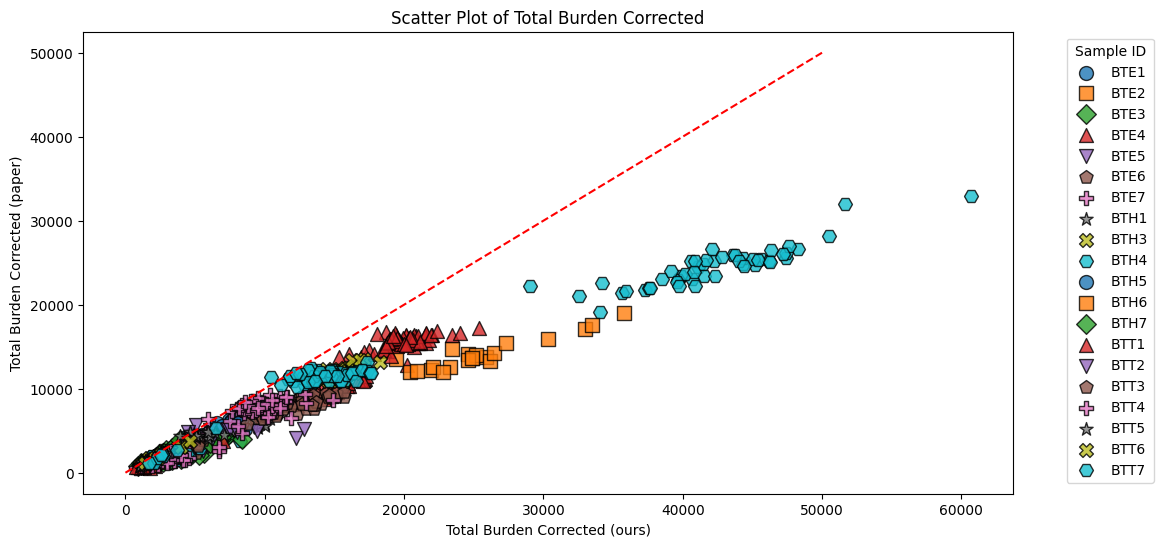

In [30]:
excel_fn = '/home/dg204/projects/brca_timing/data/external/scNanoseq/media-2.xlsx'
# sample-level statistics
supplementary_table_4 = pd.read_excel(excel_fn, sheet_name='Supplementary Table 4')
supplementary_table_4.head(1)

supplementary_table_4_simpler = supplementary_table_4.loc[:,['Sample', 'CellPhy_stem_length_per_2N']]
supplementary_table_4_simpler = supplementary_table_4_simpler[(supplementary_table_4_simpler['Sample'].notna()) & (supplementary_table_4_simpler['Sample'].str.contains('B'))]
supplementary_table_4_simpler.head()
supplementary_table_4_simpler.columns = ['sample_id', 'total_burden_corr']
supplementary_table_4_simpler['data_type'] = 'trunk'
supplementary_table_4_simpler['cell_name'] = supplementary_table_4_simpler['sample_id'] + '_trunk'

# cell-level stats
supplementary_table_2 = pd.read_excel(excel_fn, sheet_name='Supplementary Table 2')
supplementary_table_2_simpler = supplementary_table_2.loc[:,['Cancer', 'Cell_ID',  'De_novo_estimation_per_2N']]
supplementary_table_2_simpler.columns = ['sample_id', 'cell_name', 'total_burden_corr']
supplementary_table_2_simpler['data_type'] = 'scPaper'
supplementary_table_2_simpler.head(1)

# so we can compare the new and the old mutational burden
merged_cell_data3 = pd.merge(merged_cell_data, supplementary_table_2_simpler, left_on='cell_name', right_on='cell_name', how='left')
merged_cell_data3.head(1)

# Define unique markers for each sample
unique_samples = merged_cell_data3['sample_id_x'].unique()
markers = ['o', 's', 'D', '^', 'v', 'p', 'P', '*', 'X', 'H']  # Define enough marker styles

# Create figure
plt.figure(figsize=(12, 6))

# Loop through each sample and plot separately
for i, sample in enumerate(unique_samples):
    subset = merged_cell_data3[merged_cell_data3['sample_id_x'] == sample]  # Filter data for the sample
    plt.scatter(
        subset['total_burden_corr_x'], 
        subset['total_burden_corr_y'], 
        label=sample,
        marker=markers[i % len(markers)],  # Cycle through markers
        edgecolors='black', 
        s=100,  # Adjust point size
        alpha=0.8  # Transparency for better visibility
    )

# Labels and title
plt.xlabel('Total Burden Corrected (ours)')
plt.ylabel('Total Burden Corrected (paper)')
plt.title('Scatter Plot of Total Burden Corrected')

# Legend adjustments
plt.legend(title='Sample ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a diagonal reference line
plt.plot([0, 5e4], [0, 5e4], color='red', linestyle='--', linewidth=1.5)


In [31]:
duplicate_indices = merged_cell_data2_sigs.index[merged_cell_data2_sigs.index.duplicated()].unique()
duplicate_indices

Index([], dtype='object')

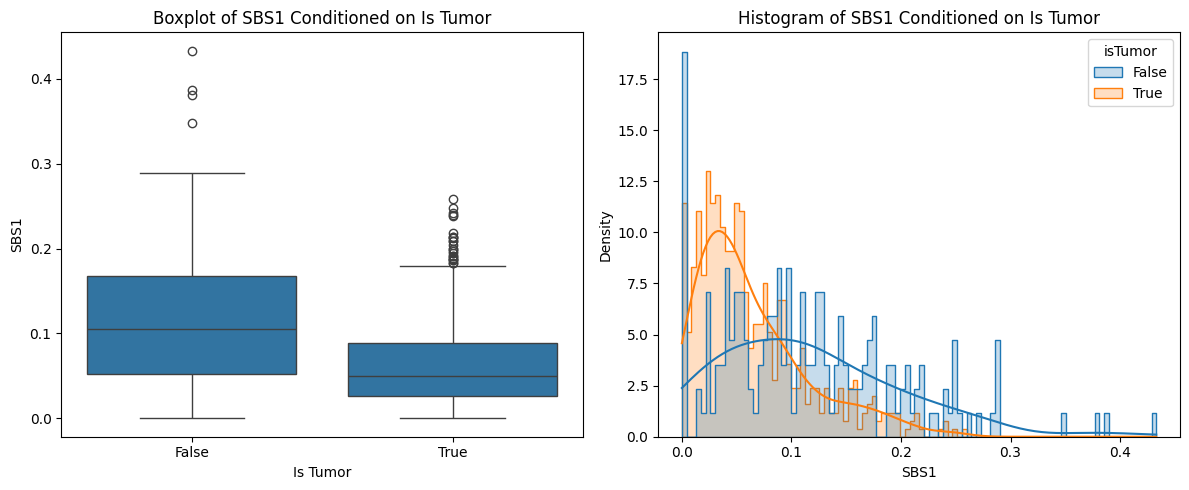

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# First plot: Boxplot of SBS1 conditioned on isTumor variable
sns.boxplot(
    x='isTumor',
    y='SBS1',
    data=merged_cell_data2_sigs,
    ax=axes[0]
)
axes[0].set_xlabel('Is Tumor')
axes[0].set_ylabel('SBS1')
axes[0].set_title('Boxplot of SBS1 Conditioned on Is Tumor')

# Second plot: Histogram of SBS1 conditioned on isTumor variable
sns.histplot(
    data=merged_cell_data2_sigs, 
    x='SBS1', 
    hue='isTumor', 
    bins=100, 
    kde=True, 
    element='step', 
    stat='density', 
    common_norm=False,
    ax=axes[1]
)
axes[1].set_xlabel('SBS1')
axes[1].set_ylabel('Density')
axes[1].set_title('Histogram of SBS1 Conditioned on Is Tumor')

plt.tight_layout()
plt.show()

In [33]:
merged_cell_data2_sigs[['sample_id_x','SBS1', 'data_type_x']]['data_type_x'].value_counts()

trunk_cell       585
scTumor          585
scNormal         187
normal_merged     21
trunk_tree        20
other              9
Name: data_type_x, dtype: int64

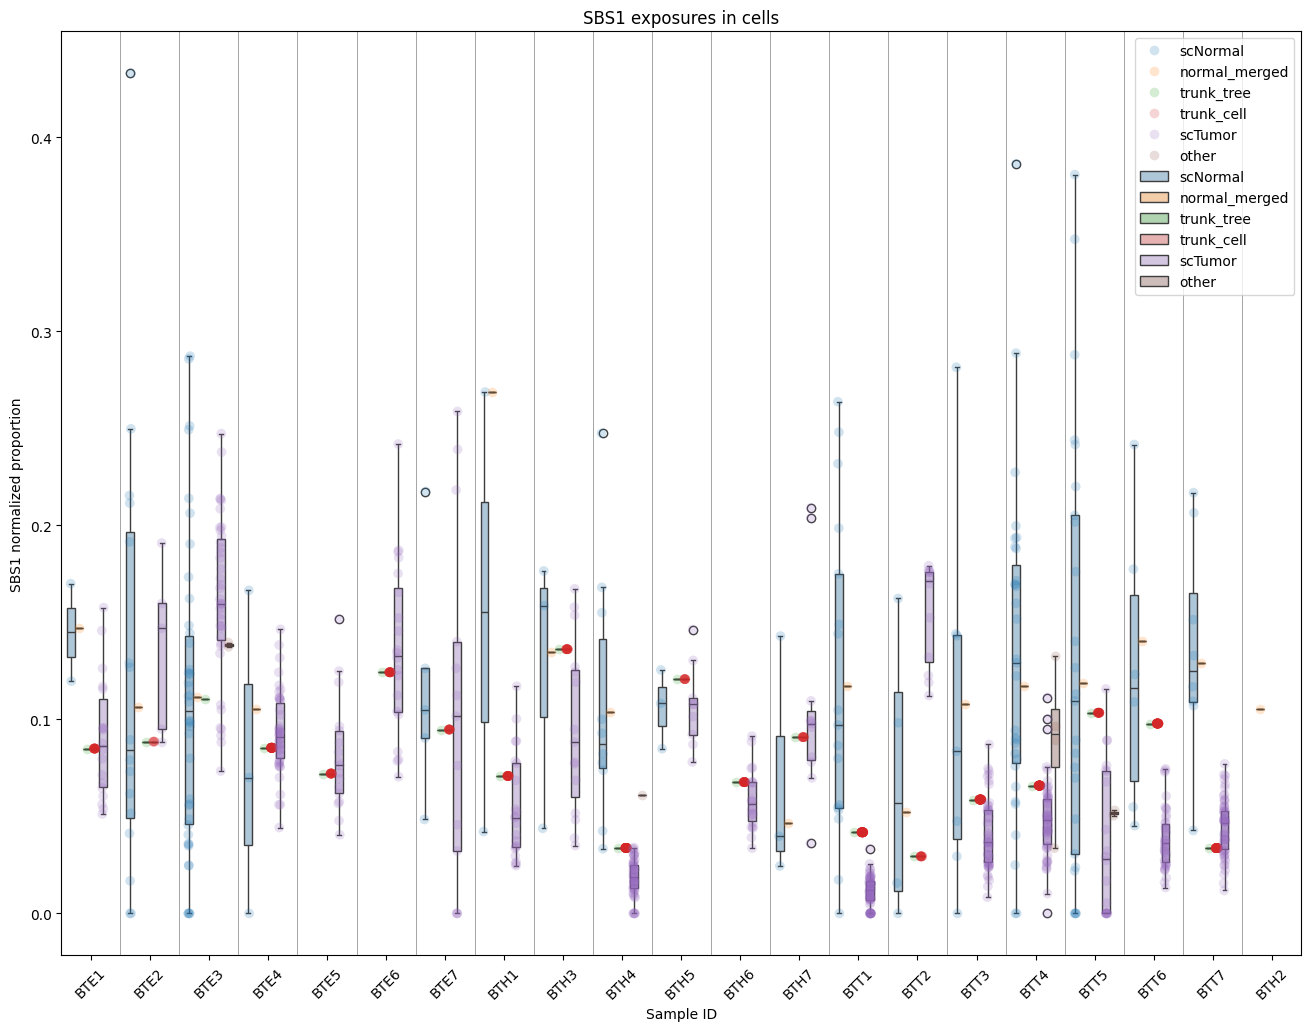

In [34]:
# Plotting
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 12))  # Width x Height in inches

# Create the stripplot
sns.stripplot(
    x='sample_id_x',
    y='SBS1',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs,
    jitter=True,
    dodge=True,
    alpha=0.2,
    size=7  # Increase the size of the points
)

# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id_x',
    y='SBS1',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs,
    width=0.8
)
for patch in boxplot.patches:
    patch.set_facecolor((patch.get_facecolor()[0],  # Retain original color
                         patch.get_facecolor()[1], 
                         patch.get_facecolor()[2], 
                         0.4))  # Set alpha for transparency

# Add vertical dividers
for i in range(1, len(merged_cell_data2_sigs['sample_id_x'].unique())):
    plt.axvline(x=i - 0.5, color='gray', linewidth=0.5)

# Customize the plot
plt.xlabel('Sample ID')
plt.ylabel('SBS1 normalized proportion')
plt.title('SBS1 exposures in cells')
plt.xticks(rotation=45)


plt.legend(loc='upper right')
plt.show()

In [35]:
all_cells = merged_cell_data['cell_name']
sel_cells = transformed_cancer_cells + normal_curated_cells + remnant_cells

In [36]:
merged_cell_data

,cell_name,m_over_T_sum,length_in_CN[Mb],total_burden,mult_sum,footprint_bp,detected_muts,power_burden_product_sum,trunk_total_burden,mult_sum_trunk,m_over_T_sum_trunk,detected_muts_trunk,power_burden_product_sum_trunk,trunk_bulk_total_burden,mult_sum_trunk_bulk,m_over_T_sum_trunk_bulk,detected_muts_trunk_bulk,power_burden_product_sum_trunk_bulk,raw_mutation_count,weighted_avg_CN,G,mult_avg,mult_avg_trunk_bulk,burden_diploid,mult_trunk_avg,burden_trunk_diploid,burden_trunk_bulk_diploid,isTumor,sample_id,sample_id_TN,cell,no_total_unf_mutations,no_discarded_mutations_BULKCOV20,perc_of_disc_muts,total_burden_corr,total_trunk_burden_corr,trunk_bulk_total_burden_corr,total_burden_corr_G,burden_diploid_corr,burden_trunk_diploid_corr,burden_trunk_bulk_diploid_corr,cell_power_exp,trunk_bulk_power_exp,data_type
0,BTE1_sc001,2284.750000,2807.553722,6354.0,7946.0,1.539041e+09,132.0,131.979528,1924.0,2435.0,629.250000,42.0,41.973726,2383.0,3094.0,902.25,51.0,50.988761,161.0,3.433530,2.781048,1.250551,1.298363,4557.205762,1.265593,1255.114006,3282.953316,True,BTE1,BTE1_T,BTE1_sc001,187,11,0.058824,7213.886894,2184.374942,4935.418959,5187.890488,4842.031122,1333.558632,3488.137898,0.020771,0.021397,scTumor
1,BTE1_sc002,1981.666667,2748.845732,4994.0,6712.0,1.531384e+09,235.0,235.107360,2073.0,2703.0,767.250000,97.0,97.041495,1649.0,2338.0,685.75,81.0,81.002925,308.0,3.431644,2.520101,1.344013,1.417829,4037.088442,1.303907,1563.056067,2507.666895,True,BTE1,BTE1_T,BTE1_sc002,389,49,0.125964,6235.770305,2588.456516,3695.971367,4948.825853,4618.904129,1788.320030,2869.065948,0.047078,0.049122,scTumor
2,BTE1_sc004,2176.583333,2809.006570,4910.0,6185.0,1.561827e+09,71.0,71.008770,1535.0,1535.0,475.750000,19.0,18.994268,1830.0,2383.0,838.00,28.0,27.513789,82.0,3.101829,2.255829,1.259674,1.302186,4339.209027,1.000000,948.449188,3004.685788,True,BTE1,BTE1_T,BTE1_sc004,105,7,0.066667,5618.407243,1756.467437,3766.193114,4981.234853,4649.152529,1016.195558,3219.306201,0.014462,0.015035,scTumor
3,BTE1_sc005,2169.166667,2739.974493,4549.0,6856.0,1.515124e+09,134.0,133.795541,898.0,1492.0,412.500000,32.0,30.733169,1757.0,2265.0,684.00,46.0,46.007550,171.0,3.383520,2.097119,1.507144,1.289129,4433.374604,1.661470,843.073542,2528.109710,True,BTE1,BTE1_T,BTE1_sc005,215,22,0.102326,5548.451863,1095.297818,3875.484061,5291.500036,4938.733367,939.175189,2816.288019,0.029412,0.026185,scTumor
4,BTE1_sc008,2339.166667,2832.853327,4491.0,6932.0,1.561827e+09,168.0,167.516795,1375.0,1790.0,519.916667,47.0,47.006608,1477.0,2315.0,776.50,57.0,56.573469,207.0,3.227630,1.919914,1.543532,1.567366,4624.077501,1.301818,1027.774119,2784.174838,True,BTE1,BTE1_T,BTE1_sc008,254,22,0.086614,5206.980513,1594.210244,3106.093315,5424.179581,5062.567609,1125.235458,3048.191418,0.037301,0.038303,scTumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,BTT7_sc202,1061.833333,3036.302756,2103.0,2103.0,8.260384e+08,34.0,33.995897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,1.992239,1.980537,1.000000,NaN,1958.390564,NaN,NaN,NaN,False,BTT7,BTT7_N,BTT7_sc202,57,13,0.228070,2691.768043,NaN,NaN,2718.220669,2537.005958,NaN,NaN,0.016165,NaN,scNormal
777,BTT7_sc203,852.000000,3036.302756,1612.0,1704.0,8.260384e+08,41.0,40.983169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,1.990792,1.892019,1.057072,NaN,1571.384800,NaN,NaN,NaN,False,BTT7,BTT7_N,BTT7_sc203,66,19,0.287879,2236.594724,NaN,NaN,2364.241569,2206.625464,NaN,NaN,0.025424,NaN,scNormal
778,BTT7_sc204,1088.500000,3036.302756,2020.0,2142.0,8.260384e+08,42.0,42.003926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,1.964720,1.855765,1.060396,NaN,2007.573187,NaN,NaN,NaN,False,BTT7,BTT7_N,BTT7_sc204,64,15,0.234375,2606.822401,NaN,NaN,2809.431865,2622.136407,NaN,NaN,0.020794,NaN,scNormal
779,BTT7_sc205,541.000000,3036.302756,1082.0,1082.0,8.260384e+08,16.0,15.995531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.

In [37]:
merged_cell_data2_sigs[merged_cell_data2_sigs['cell_name'].isin(['BTH4_sc005', 'BTT4_sc033'])][['data_type_x', 'isTumor']]

,data_type_x,isTumor
273,other,False
544,other,False


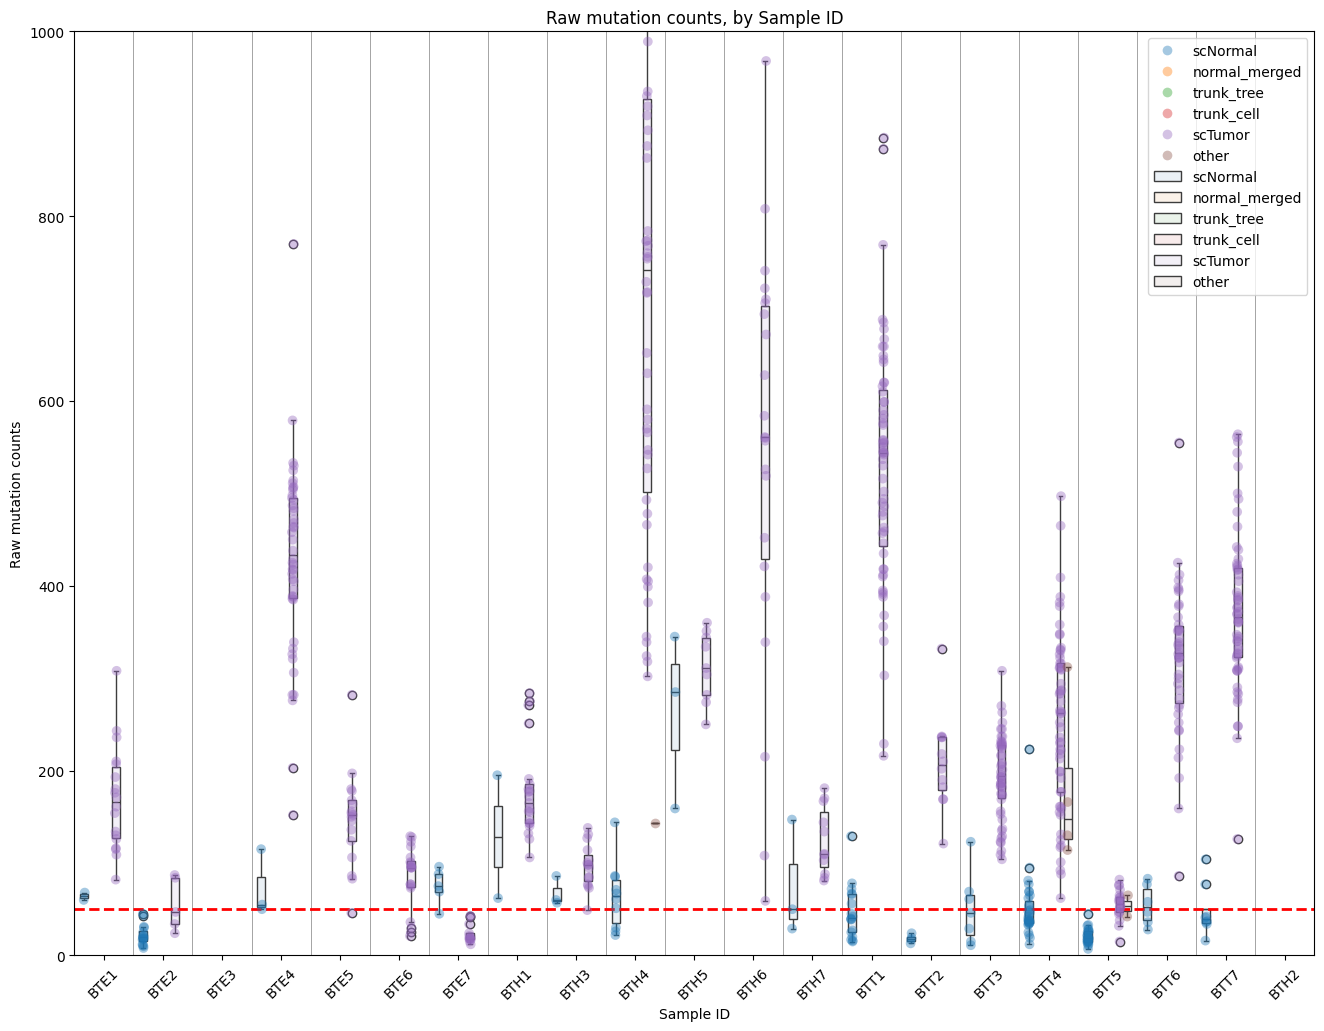

In [38]:
# Plotting
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 12))  # Width x Height in inches

# Create the stripplot
sns.stripplot(
    x='sample_id_x',
    y='raw_mutation_count',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs,
    jitter=True,
    dodge=True,
    alpha=0.4,
    size=7  # Increase the size of the points
)

# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id_x',
    y='raw_mutation_count',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs,
    width=0.8
)
for patch in boxplot.patches:
    patch.set_facecolor((patch.get_facecolor()[0],  # Retain original color
                         patch.get_facecolor()[1], 
                         patch.get_facecolor()[2], 
                         0.1))  # Set alpha for transparency

# Add vertical dividers
for i in range(1, len(merged_cell_data2_sigs['sample_id_x'].unique())):
    plt.axvline(x=i - 0.5, color='gray', linewidth=0.5)

# Customize the plot
plt.ylim(0, 1000)
plt.xlabel('Sample ID')
plt.ylabel('Raw mutation counts')
plt.title('Raw mutation counts, by Sample ID')
plt.xticks(rotation=45)

plt.axhline(y=50, color='red', linestyle='--', linewidth=2)


plt.legend(loc='upper right')
plt.show()

In [39]:
merged_cell_data[['sample_id', 'isTumor', 'detected_muts', 'detected_muts_trunk_bulk']]

,sample_id,isTumor,detected_muts,detected_muts_trunk_bulk
0,BTE1,True,132.0,51.0
1,BTE1,True,235.0,81.0
2,BTE1,True,71.0,28.0
3,BTE1,True,134.0,46.0
4,BTE1,True,168.0,57.0
...,...,...,...,...
776,BTT7,False,34.0,NaN
777,BTT7,False,41.0,NaN
778,BTT7,False,42.0,NaN
779,BTT7,False,16.0,NaN


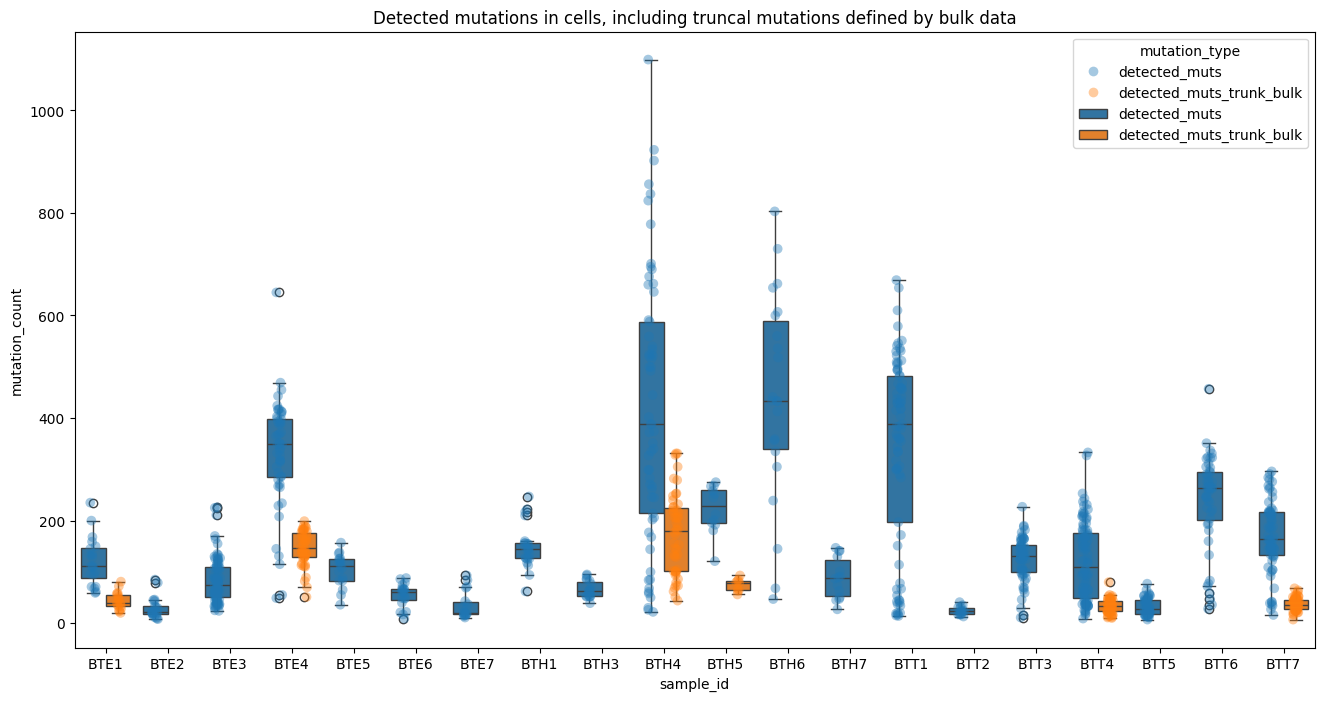

In [40]:
# Plotting
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 8))  # Width x Height in inches

# Melt the dataframe to long format
melted_data = merged_cell_data.melt(id_vars=['sample_id'], value_vars=['detected_muts', 'detected_muts_trunk_bulk'], 
                                    var_name='mutation_type', value_name='mutation_count')

# Create the stripplot
sns.stripplot(
    x='sample_id',
    y='mutation_count',
    hue='mutation_type',
    data=melted_data,
    jitter=True,
    dodge=True,
    alpha=0.4,
    size=7  # Increase the size of the points
)



# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id',
    y='mutation_count',
    hue='mutation_type',
    data=melted_data,
    width=0.8
)

plt.title('Detected mutations in cells, including truncal mutations defined by bulk data')
plt.show()

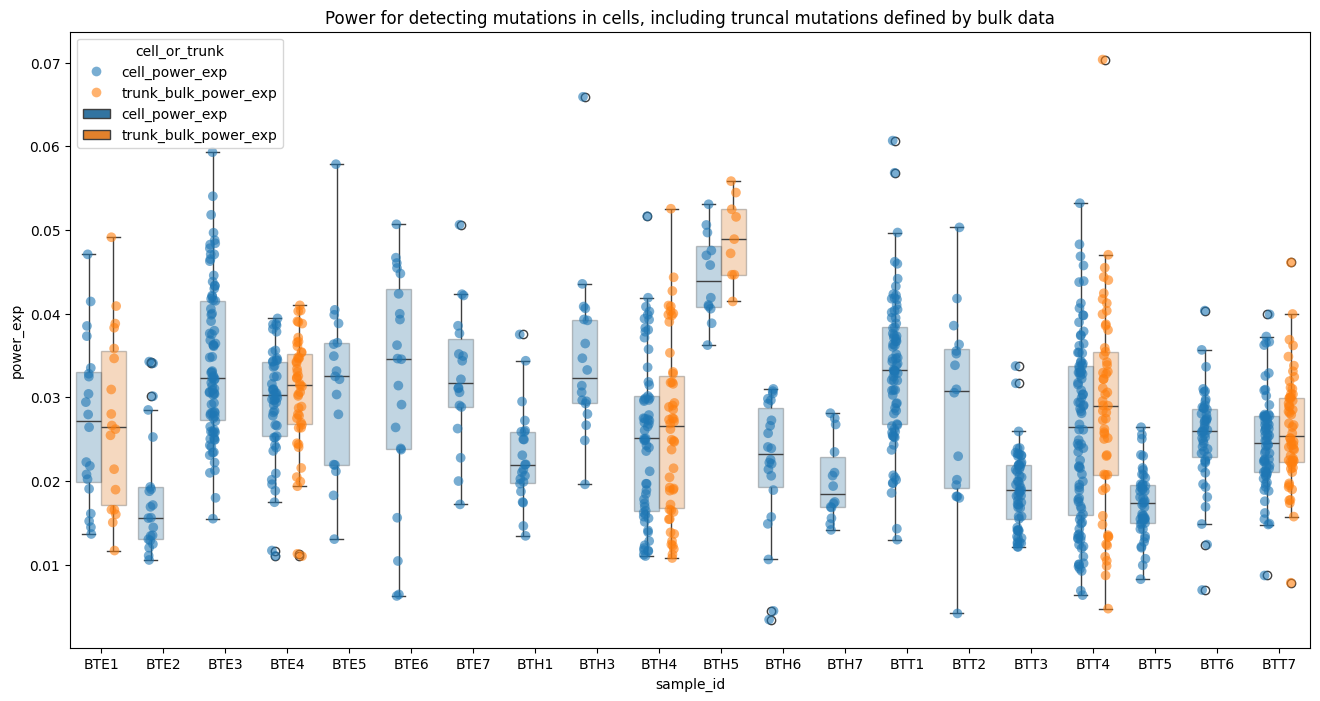

In [41]:
#merged_cell_data[['sample_id', 'power_burden_product_sum', 'total_burden', 'cell_power_exp', 'trunk_bulk_power_exp', 'mult_avg', 'mult_avg_trunk_bulk']]
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 8))  # Width x Height in inches

# Melt the dataframe to long format
melted_data = merged_cell_data.melt(id_vars=['sample_id'], value_vars=['cell_power_exp', 'trunk_bulk_power_exp'], 
                                    var_name='cell_or_trunk', value_name='power_exp')


# Create the stripplot
sns.stripplot(
    x='sample_id',
    y='power_exp',
    hue='cell_or_trunk',
    data=melted_data,
    jitter=True,
    dodge=True,
    alpha=0.6,
    size=7  # Increase the size of the points
)



# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id',
    y='power_exp',
    hue='cell_or_trunk',
    data=melted_data,
    width=0.8
)

# Set transparency (alpha) for the boxes
for patch in boxplot.patches:
    patch.set_alpha(0.3)  # Adjust transparency here

plt.title('Power for detecting mutations in cells, including truncal mutations defined by bulk data')


plt.savefig(
    '/home/dg204/projects/brca_timing/data/processed/paperPlots_Apr25/powerAcrossCells.pdf',
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata for Illustrator
)
plt.show()


In [42]:
merged_cell_data['cell_power_exp'].median()

0.026296409539355994

In [43]:
merged_cell_data['cell_power_exp'].quantile(0.25)

0.019538843376318876

In [44]:
merged_cell_data['cell_power_exp'].quantile(0.75)

0.033575235028603406

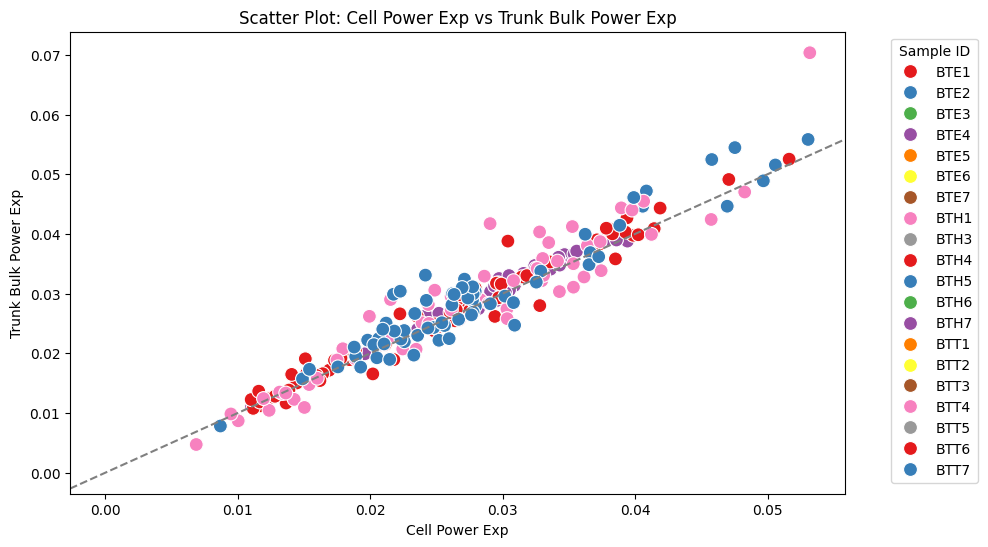

In [45]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=merged_cell_data,
    x='cell_power_exp',
    y='trunk_bulk_power_exp',
    hue='sample_id',
    palette='Set1',
    s=100  # Adjust marker size
)

plt.xlabel('Cell Power Exp')
plt.ylabel('Trunk Bulk Power Exp')
plt.title('Scatter Plot: Cell Power Exp vs Trunk Bulk Power Exp')
plt.legend(title='Sample ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axline((0, 0), slope=1, color='gray', linestyle='--')
plt.show()


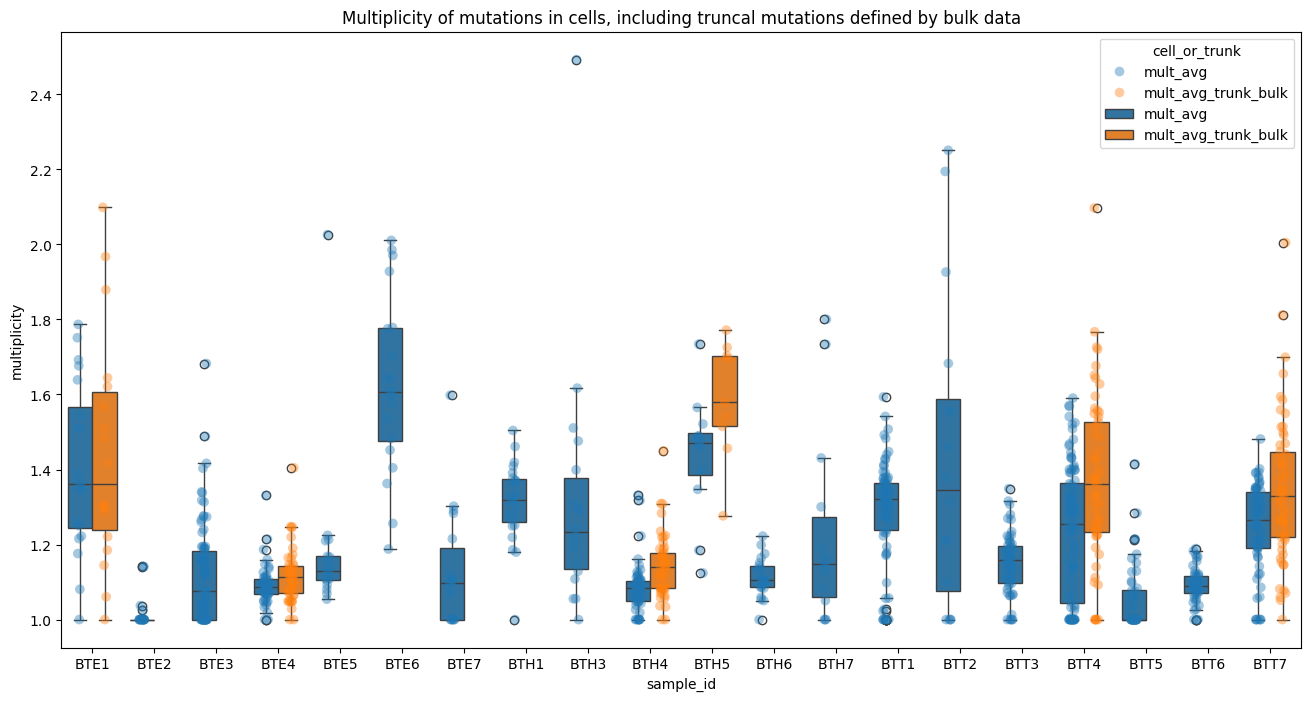

In [46]:
#merged_cell_data[['sample_id', 'power_burden_product_sum', 'total_burden', 'cell_power_exp', 'trunk_bulk_power_exp', 'mult_avg', 'mult_avg_trunk_bulk']]
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 8))  # Width x Height in inches

# Melt the dataframe to long format
melted_data = merged_cell_data.melt(id_vars=['sample_id'], value_vars=['mult_avg', 'mult_avg_trunk_bulk'], 
                                    var_name='cell_or_trunk', value_name='multiplicity')


# Create the stripplot
sns.stripplot(
    x='sample_id',
    y='multiplicity',
    hue='cell_or_trunk',
    data=melted_data,
    jitter=True,
    dodge=True,
    alpha=0.4,
    size=7  # Increase the size of the points
)



# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id',
    y='multiplicity',
    hue='cell_or_trunk',
    data=melted_data,
    width=0.8
)



plt.title('Multiplicity of mutations in cells, including truncal mutations defined by bulk data')
plt.show()


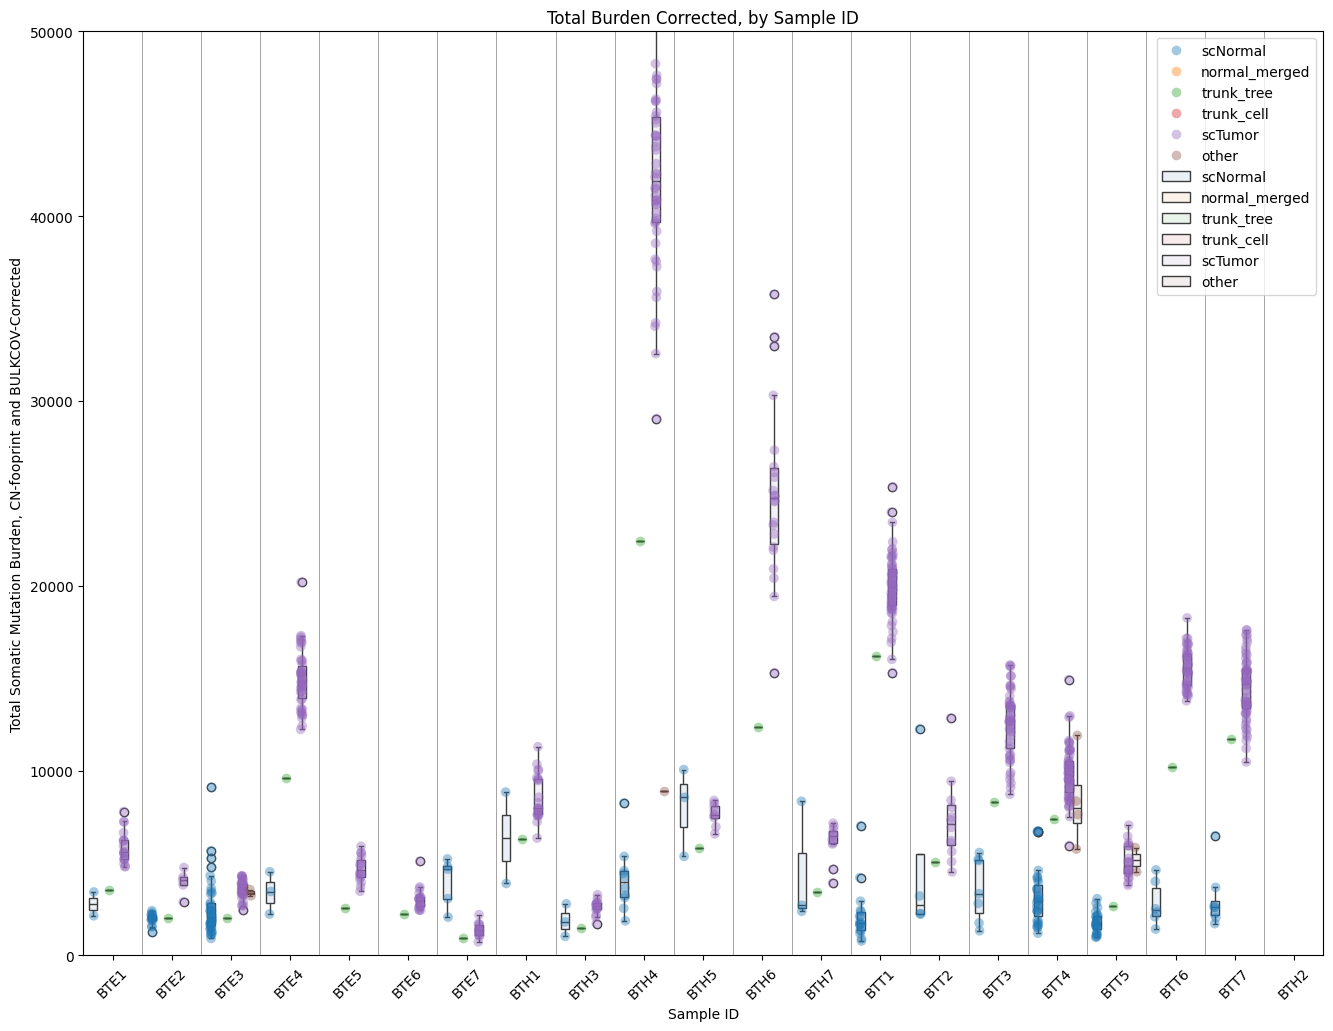

In [47]:
# Plotting
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 12))  # Width x Height in inches

# Create the stripplot
sns.stripplot(
    x='sample_id_x',
    y='total_burden_corr',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs,
    jitter=True,
    dodge=True,
    alpha=0.4,
    size=7  # Increase the size of the points
)

# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id_x',
    y='total_burden_corr',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs,
    width=0.8
)
for patch in boxplot.patches:
    patch.set_facecolor((patch.get_facecolor()[0],  # Retain original color
                         patch.get_facecolor()[1], 
                         patch.get_facecolor()[2], 
                         0.1))  # Set alpha for transparency

# Add vertical dividers
for i in range(1, len(merged_cell_data2_sigs['sample_id_x'].unique())):
    plt.axvline(x=i - 0.5, color='gray', linewidth=0.5)

# Customize the plot
plt.ylim(0, 50000)
plt.xlabel('Sample ID')
plt.ylabel('Total Somatic Mutation Burden, CN-fooprint and BULKCOV-Corrected')
plt.title('Total Burden Corrected, by Sample ID')
plt.xticks(rotation=45)


plt.legend(loc='upper right')
plt.show()

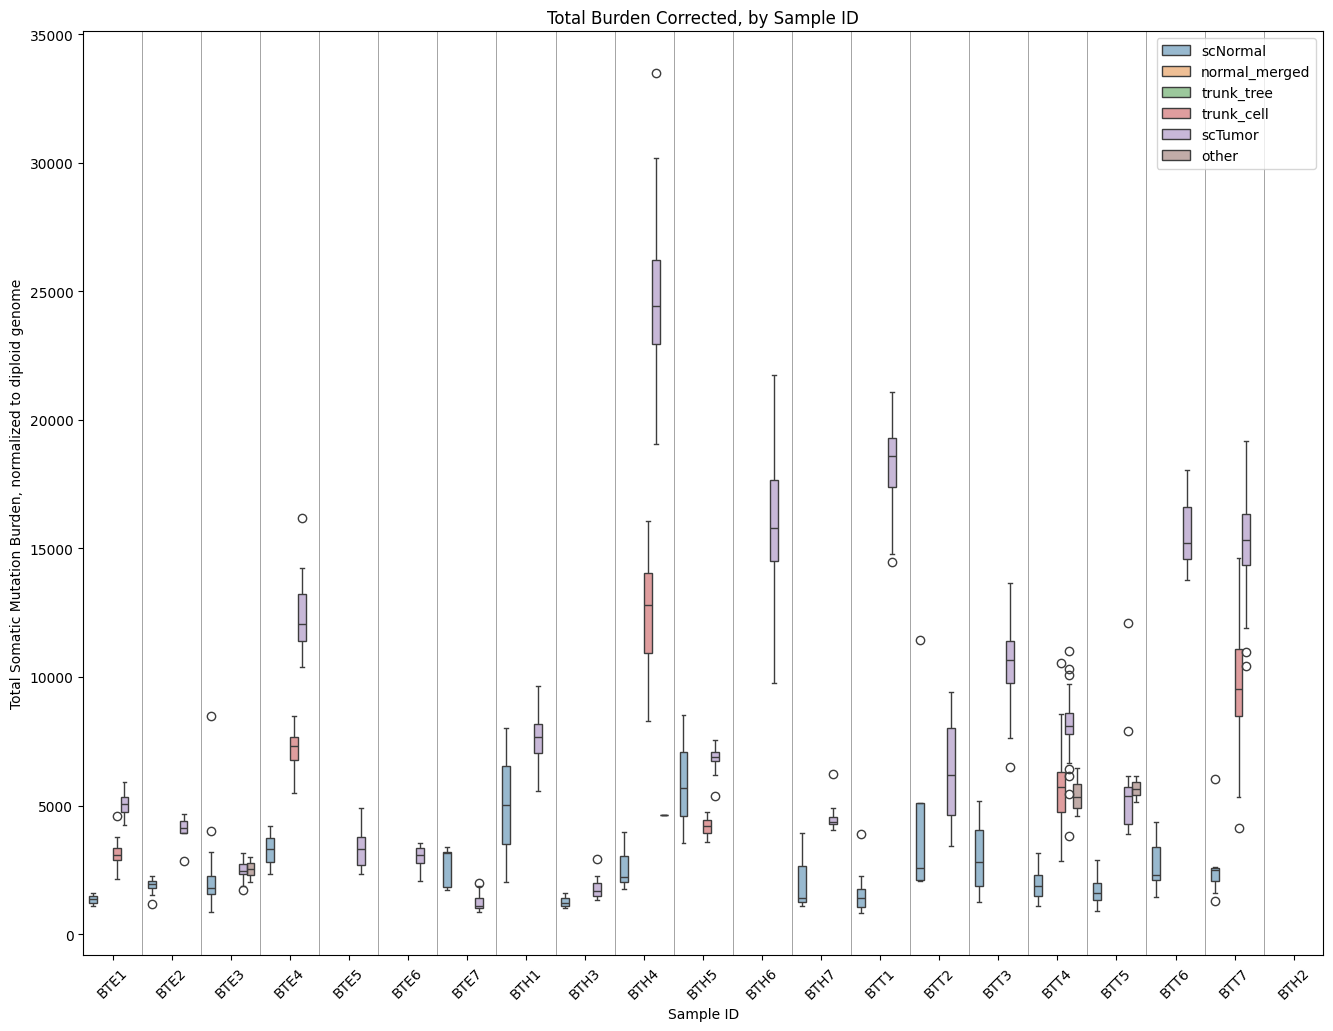

In [48]:
# Plotting
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 12))  # Width x Height in inches

# Create the stripplot
#sns.stripplot(
#    x='sample_id_x',
#    y='burden_diploid_corr',
#    hue='data_type_x',  # Conditional column
#    data=merged_cell_data2_sigs,
#    jitter=True,
#    dodge=True,
#    alpha=0.4,
#    size=7  # Increase the size of the points
#)

# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id_x',
    y='burden_diploid_corr',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs,
    width=0.8
)
for patch in boxplot.patches:
    patch.set_facecolor((patch.get_facecolor()[0],  # Retain original color
                         patch.get_facecolor()[1], 
                         patch.get_facecolor()[2], 
                         0.5))  # Set alpha for transparency

# Add vertical dividers
for i in range(1, len(merged_cell_data2_sigs['sample_id_x'].unique())):
    plt.axvline(x=i - 0.5, color='gray', linewidth=0.5)

# Customize the plot
plt.xlabel('Sample ID')
plt.ylabel('Total Somatic Mutation Burden, normalized to diploid genome')
plt.title('Total Burden Corrected, by Sample ID')
plt.xticks(rotation=45)


plt.legend(loc='upper right')
plt.show()

In [49]:
pd.set_option('display.max_columns', None)
median_burden_diploid_corr = merged_cell_data2_sigs.groupby(['sample_id_x', 'data_type_x'])['burden_diploid_corr'].median().reset_index()
pd.DataFrame(median_burden_diploid_corr.T).reset_index()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0,sample_id_x,BTE1,BTE1,BTE1,BTE1,BTE1,BTE1,BTE2,BTE2,BTE2,BTE2,BTE2,BTE2,BTE3,BTE3,BTE3,BTE3,BTE3,BTE3,BTE4,BTE4,BTE4,BTE4,BTE4,BTE4,BTE5,BTE5,BTE5,BTE5,BTE5,BTE5,BTE6,BTE6,BTE6,BTE6,BTE6,BTE6,BTE7,BTE7,BTE7,BTE7,BTE7,BTE7,BTH1,BTH1,BTH1,BTH1,BTH1,BTH1,BTH2,BTH2,BTH2,BTH2,BTH2,BTH2,BTH3,BTH3,BTH3,BTH3,BTH3,BTH3,BTH4,BTH4,BTH4,BTH4,BTH4,BTH4,BTH5,BTH5,BTH5,BTH5,BTH5,BTH5,BTH6,BTH6,BTH6,BTH6,BTH6,BTH6,BTH7,BTH7,BTH7,BTH7,BTH7,BTH7,BTT1,BTT1,BTT1,BTT1,BTT1,BTT1,BTT2,BTT2,BTT2,BTT2,BTT2,BTT2,BTT3,BTT3,BTT3,BTT3,BTT3,BTT3,BTT4,BTT4,BTT4,BTT4,BTT4,BTT4,BTT5,BTT5,BTT5,BTT5,BTT5,BTT5,BTT6,BTT6,BTT6,BTT6,BTT6,BTT6,BTT7,BTT7,BTT7,BTT7,BTT7,BTT7
1,data_type_x,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other,scNormal,normal_merged,trunk_tree,trunk_cell,scTumor,other
2,burden_diploid_corr,1352.879257,NaN,NaN,3083.161027,5074.709549,NaN,1932.418263,NaN,NaN,NaN,4109.363174,NaN,1800.477086,NaN,NaN,NaN,2466.436853,2526.228694,3291.708289,NaN,NaN,7313.410337,12061.255703,NaN,NaN,NaN,NaN,NaN,3315.4968,NaN,NaN,NaN,NaN,NaN,3076.432832,NaN,3153.920744,NaN,NaN,NaN,1075.67243,NaN,5023.598384,NaN,NaN,NaN,7659.892955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208.042685,NaN,NaN,NaN,1695.307145,NaN,2202.660794,NaN,NaN,12812.189219,24444.805195,4642.508763,5670.69385,NaN,NaN,4205.228475,6904.03222,NaN,NaN,NaN,NaN,NaN,15808.157371,NaN,1408.264023,NaN,NaN,NaN,4351.40737,NaN,1387.251116,NaN,NaN,NaN,18607.962849,NaN,2561.100876,NaN,NaN,NaN,6178.863369,NaN,2813.972634,NaN,NaN,NaN,10675.173186,NaN,1854.53422,NaN,NaN,5725.772851,8083.221951,5326.645826,1604.429375,NaN,NaN,NaN,5374.501525,5658.659141,2312.566927,NaN,NaN,NaN,15220.916918,NaN,2476.056143,NaN,NaN,9536.141022,15332.180322,NaN


/home/dg204/jupytervenv3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Text(0, 0.5, 'our estimate of trunk mutational burden (median across cells)')

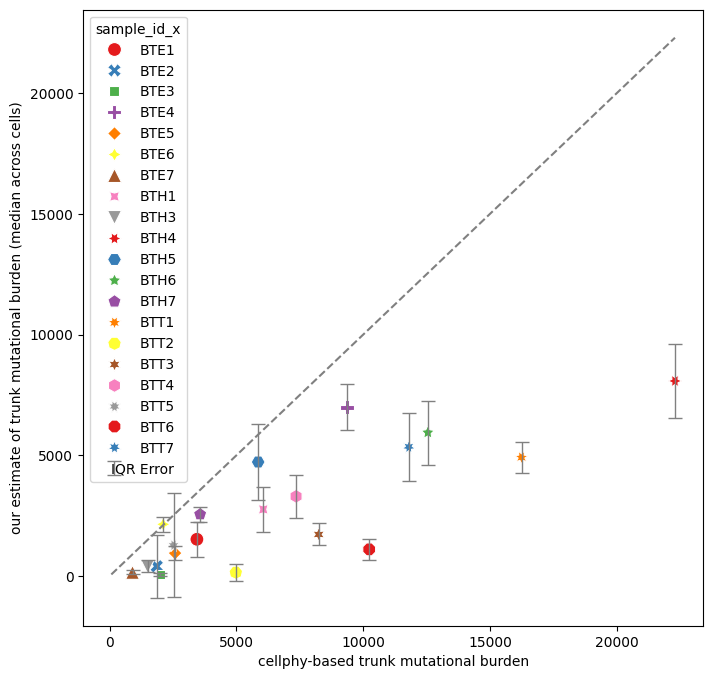

In [50]:
trunk_burden_ours = merged_cell_data.groupby('sample_id').agg({
    'total_trunk_burden_corr': [  # Calculate both median and IQR
        'median', 
        lambda x: np.nanpercentile(x, 75) - np.nanpercentile(x, 25)  # IQR = Q3 - Q1
    ],
    'trunk_bulk_total_burden_corr': [  # Calculate both median and IQR
        'median', 
        lambda x: np.nanpercentile(x, 75) - np.nanpercentile(x, 25)  # IQR = Q3 - Q1
    ]
}).reset_index()


# Rename columns for clarity
trunk_burden_ours.columns = ['sample_id', 'trunk_total_burden_median', 'trunk_total_burden_IQR', 'trunk_bulk_total_burden_median', 'trunk_bulk_total_burden_IQR']

mean_median_mrca_burden_m = pd.merge(mean_median_mrca_burden, trunk_burden_ours, left_index=True, right_on='sample_id')

plt.figure(figsize=(8, 8))

plt.errorbar(
    mean_median_mrca_burden_m['median_mrca_burden'], 
    mean_median_mrca_burden_m['trunk_total_burden_median'], 
    yerr=mean_median_mrca_burden_m['trunk_total_burden_IQR'], 
    fmt='none', 
    capsize=5, 
    capthick=1, 
    elinewidth=1, 
    ecolor='gray',  # Color of error bars
    label='IQR Error',
)



sns.scatterplot(
    data=mean_median_mrca_burden_m, 
    x='median_mrca_burden', 
    y='trunk_total_burden_median', 
    hue='sample_id_x', 
    style='sample_id_x',
    palette='Set1', 
    s=100  # Adjust marker size
)


min_val = min(mean_median_mrca_burden_m['median_mrca_burden'].min(), mean_median_mrca_burden_m['trunk_total_burden_median'].min())
max_val = max(mean_median_mrca_burden_m['median_mrca_burden'].max(), mean_median_mrca_burden_m['trunk_total_burden_median'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="gray", label="y = x")
plt.xlabel('cellphy-based trunk mutational burden')
plt.ylabel('our estimate of trunk mutational burden (median across cells)')

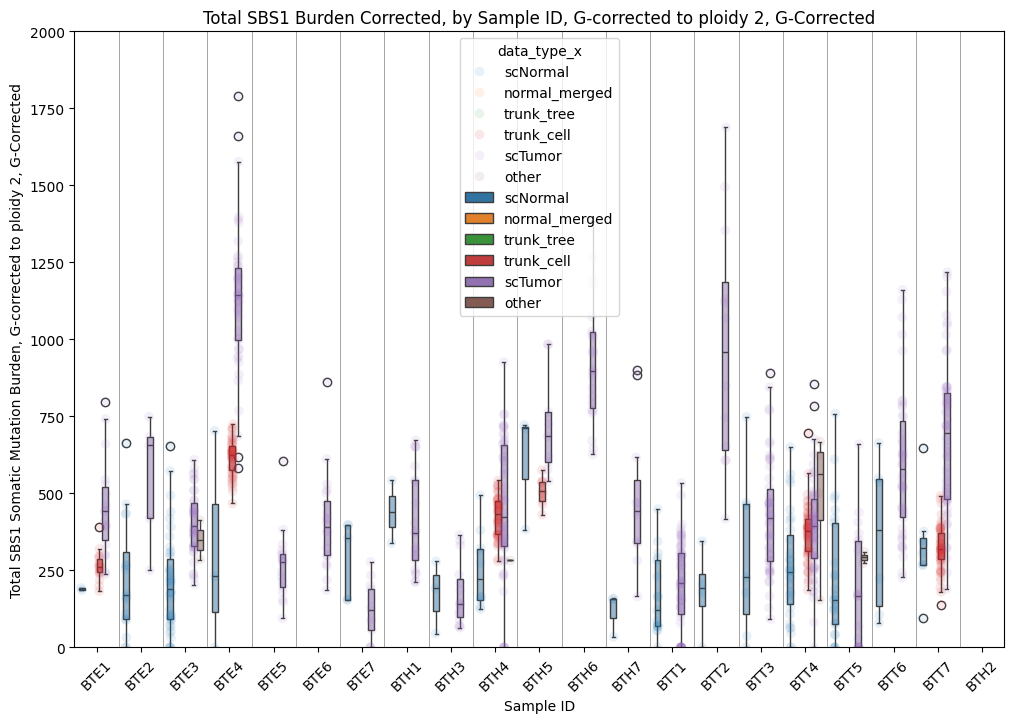

In [51]:



mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(12, 8))

# Set font to Arial for Illustrator compatibility
#matplotlib.rcParams['font.family'] = 'Arial'

# Create the stripplot
sns.stripplot(
    x='sample_id_x',
    y='burden_diploid_corr_SBS1',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs,
    jitter=True,
    dodge=True,
    alpha=0.1,
    size=7  # Increase the size of the points
)

# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id_x',
    y='burden_diploid_corr_SBS1',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs,
    width=0.8
)
for patch in boxplot.patches:
    patch.set_facecolor((patch.get_facecolor()[0],  # Retain original color
                         patch.get_facecolor()[1], 
                         patch.get_facecolor()[2], 
                         0.5))  # Set alpha for transparency

# Add vertical dividers
for i in range(1, 21):
    plt.axvline(x=i - 0.5, color='gray', linewidth=0.5)

# Customize the plot
plt.ylim(0, 2000)
plt.xlabel('Sample ID')
plt.ylabel('Total SBS1 Somatic Mutation Burden, G-corrected to ploidy 2, G-Corrected')
plt.title('Total SBS1 Burden Corrected, by Sample ID, G-corrected to ploidy 2, G-Corrected')
plt.xticks(rotation=45)

# Save as PDF with editable text
#plt.savefig(
#    '/home/dg204/projects/brca_timing/data/processed/paperPlots_Dec24/Figure5_all_cells_SBS1.pdf',
#    format='pdf',
#    dpi=300,                # High resolution
#    bbox_inches='tight',    # Trim whitespace
#    metadata={'Creator': 'Matplotlib'}  # Metadata for Illustrator
#)

plt.show()

In [52]:
#vc = merged_cell_data2_sigs_sel['sample_id_x'].value_counts()
#vc.index = vc.index.astype(str).str.strip()
#vc_sorted = vc.sort_index()
#vc_sorted

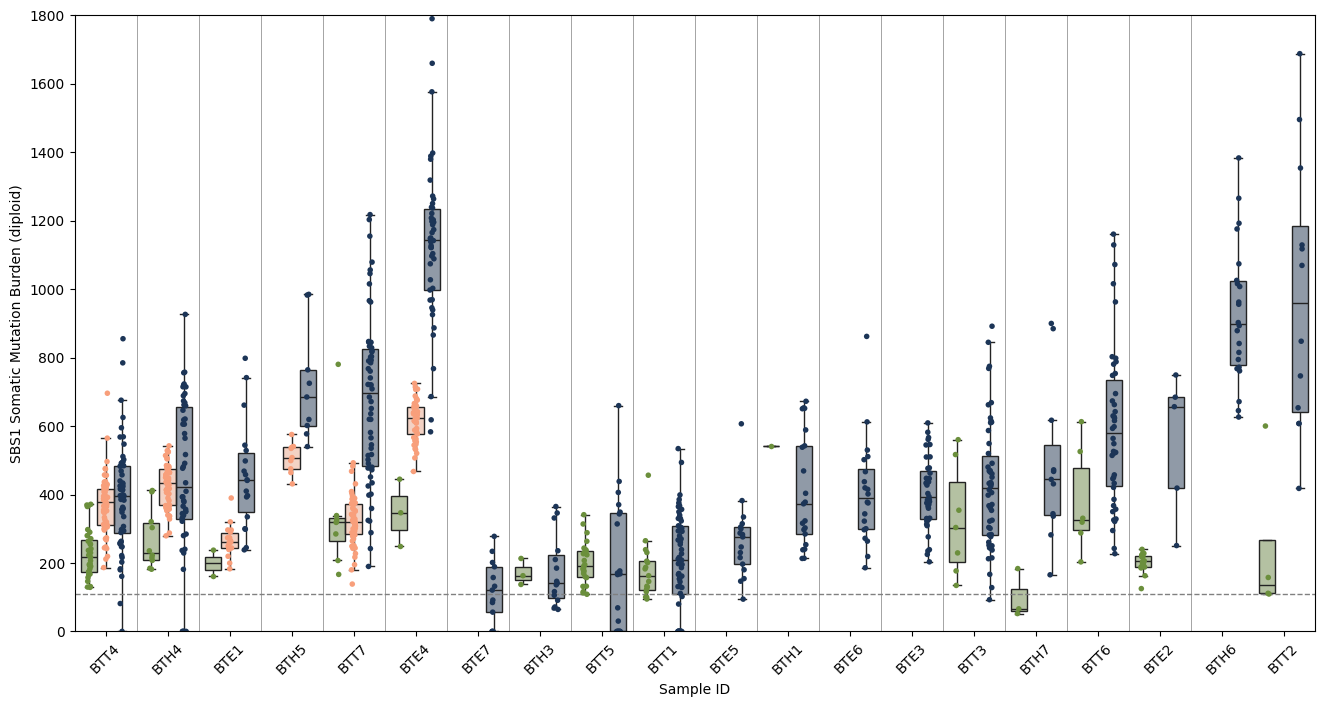

In [53]:
# the approach to signatures in normal cells is different

sel_cells = transformed_cancer_cells + normal_curated_cells
sel_cells2 = sel_cells + [c + '_trunk' for c in sel_cells]
merged_cell_data2_sigs_sel = merged_cell_data2_sigs[merged_cell_data2_sigs['cell_name'].isin(sel_cells2)].copy()
# Remove absent categories in data_type_x column
merged_cell_data2_sigs_sel['data_type_x'] = merged_cell_data2_sigs_sel['data_type_x'].cat.remove_unused_categories()
merged_cell_data2_sigs_sel = merged_cell_data2_sigs_sel[merged_cell_data2_sigs_sel['data_type_x'].isin(['scTumor', 'scNormal', 'trunk_cell'])]


custom_order = ['BTT4', 'BTH4','BTE1', 'BTH5',  'BTT7', 'BTE4'] 


df_grouped = merged_cell_data2_sigs_sel.groupby(['sample_id_x', 'data_type_x'])[['burden_diploid_corr_SBS1_merged_normal']].median().reset_index()

# Pivot the table to wide format
df_wide = df_grouped.pivot(index='sample_id_x', columns='data_type_x', values='burden_diploid_corr_SBS1_merged_normal')

# Reset index to make `sample_id_x` a column again
df_wide.reset_index(inplace=True)

df_wide['tumor_normal_diff'] = df_wide['scTumor'] - df_wide['scNormal']
df_wide['tumor_normal_diff'] = df_wide['tumor_normal_diff'].fillna(0)

# Sort by 'tumor_normal_diff' in ascending order
df_wide = df_wide.sort_values(by='scTumor', ascending=True)

custom_order = custom_order + [c for c in df_wide['sample_id_x'] if c not in custom_order] 

merged_cell_data2_sigs_sel['sample_id_x'] = pd.Categorical(merged_cell_data2_sigs_sel['sample_id_x'], 
                                                           categories=custom_order, ordered=True)


mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(16, 8))

# Set font to Arial for Illustrator compatibility
#matplotlib.rcParams['font.family'] = 'Arial'



# Define a color palette for the levels of data_type_x
palette = {
    'scTumor': '#1C3557',
    'scNormal': '#6B8F3C',
    'trunk_tree': 'green',
    'trunk_cell': '#F89F7B',
    'normal_merged': 'orange',
    'other': 'gray'
}

# Create the stripplot
sns.stripplot(
    x='sample_id_x',
    y='burden_diploid_corr_SBS1_merged_normal',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs_sel,
    jitter=True,
    dodge=True,  # Set dodge to True for alignment
    alpha=1,
    size=4,  # Increase the size of the points
    palette=palette  # Assign the color palette
)

# Overlay the boxplot with transparency
boxplot = sns.boxplot(
    x='sample_id_x',
    y='burden_diploid_corr_SBS1_merged_normal',
    hue='data_type_x',  # Conditional column
    data=merged_cell_data2_sigs_sel,
    width=0.8,
    palette=palette,  # Assign the color palette
    linewidth=1,  # Make the black lines thicker
    showfliers=False  # Do not show outliers
)

# Remove the legend for the stripplot to avoid duplication
sns.move_legend(boxplot, "upper right")





for patch in boxplot.patches:
    patch.set_facecolor((patch.get_facecolor()[0],  # Retain original color
                         patch.get_facecolor()[1], 
                         patch.get_facecolor()[2], 
                         0.5))  # Set alpha for transparency

# Add vertical dividers
for i in range(1, 19):
    plt.axvline(x=i - 0.5, color='gray', linewidth=0.5)

# Customize the plot
plt.ylim(0, 1800)
plt.xlabel('Sample ID')
plt.ylabel('SBS1 Somatic Mutation Burden (diploid)')
#plt.title('Total SBS1 Burden Corrected, by Sample ID, G-corrected to ploidy 2, G-Corrected')
plt.xticks(rotation=45)

# Remove the legend
#plt.legend(loc='upper right')
plt.legend().remove()

plt.axhline(y=109, color='gray', linestyle='--', linewidth=1)
# Save as PDF with editable text
plt.savefig(
    '/home/dg204/projects/brca_timing/data/processed/paperPlots_Feb25/Figure5A.pdf',
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata for Illustrator
)
plt.show()

merged_cell_data2_sigs_sel.to_csv('/home/dg204/projects/brca_timing/data/processed/scNanoseq/scNanoseq_diploid_burdens_with_signatures_Feb25_selected.csv')


In [54]:
# see scNanoseq/reviewCorrectedBurdens.ipynb
sc_burdens_fn = '/home/dg204/projects/brca_timing/data/processed/scNanoseq/scNanoseq_burdens_with_signatures_Feb25_selected.csv'
merged_data2_sigs = pd.read_csv(sc_burdens_fn)
merged_data2_sigs['data_type_x'].value_counts()

scTumor       553
trunk_cell    553
scNormal      136
Name: data_type_x, dtype: int64

In [55]:
median_normal_burden_per_sample = merged_data2_sigs[merged_data2_sigs['data_type_x'] == 'scNormal'].groupby('sample_id_x')[['burden_diploid_corr_SBS1_merged_normal', 'burden_diploid_corr']].median().reset_index()
# scNormal; burden_diploid_corr_SBS1_merged_normal
filtered_groups_normal = merged_data2_sigs[merged_data2_sigs['data_type_x']=='scNormal'].groupby('sample_id_x').filter(lambda x: len(x) >= 5)
median_normal_burden_per_sample = filtered_groups_normal[filtered_groups_normal['data_type_x']=='scNormal'].groupby('sample_id_x')[['burden_diploid_corr_SBS1_merged_normal', 'burden_diploid_corr']].median().reset_index()
# Filter groups with at least 5 observations


median_normal_burden_per_sample = median_normal_burden_per_sample.rename(
    columns={median_normal_burden_per_sample.columns[1]: 'normal_' + median_normal_burden_per_sample.columns[1],
             median_normal_burden_per_sample.columns[2]: 'normal_' + median_normal_burden_per_sample.columns[2]})

# Calculate the median total_burden_SBS1 per sample_id_x for filtered groups
counts = merged_data2_sigs[merged_data2_sigs['data_type_x'] == 'scTumor'].groupby('sample_id_x').size()
# scTumor: burden_diploid_corr_SBS1_merged_normal
filtered_groups_tumor = merged_data2_sigs[merged_data2_sigs['data_type_x']=='scTumor'].groupby('sample_id_x').filter(lambda x: len(x) >= 5)

# Calculate the median total_burden_SBS1 per sample_id_x for filtered groups
median_tumor_burden_per_sample = filtered_groups_tumor.groupby('sample_id_x')[['burden_diploid_corr_SBS1_merged_normal', 'burden_diploid_corr']].median().reset_index()
median_tumor_burden_per_sample = median_tumor_burden_per_sample.rename(
    columns={median_tumor_burden_per_sample.columns[1]: 'tumor_' + median_tumor_burden_per_sample.columns[1],
             median_tumor_burden_per_sample.columns[2]: 'tumor_' + median_tumor_burden_per_sample.columns[2]}
)

tumor_normal_median_sbs1_burden = pd.merge(median_normal_burden_per_sample, median_tumor_burden_per_sample, on = 'sample_id_x', how='outer')
# trunk_cell: burden_diploid_corr_SBS1_merged_normal
filtered_groups = merged_data2_sigs[merged_data2_sigs['data_type_x']=='trunk_cell']

# Calculate the median total_burden_SBS1 per sample_id_x for filtered groups
trunk_burden_per_sample = filtered_groups.groupby('sample_id_x')[['burden_diploid_corr_SBS1_merged_normal', 'burden_diploid_corr']].median().reset_index()
trunk_burden_per_sample = trunk_burden_per_sample.rename(
    columns={trunk_burden_per_sample.columns[1]: 'trunk_' + trunk_burden_per_sample.columns[1],
             trunk_burden_per_sample.columns[2]: 'trunk_' + trunk_burden_per_sample.columns[2]}
)
# do not use the G correction, since this cannot be applied to trunk
tumor_trunk_median_sbs1_burden = pd.merge(median_tumor_burden_per_sample, trunk_burden_per_sample, on='sample_id_x')
normal_trunk_median_sbs1_burden = pd.merge(median_normal_burden_per_sample, trunk_burden_per_sample, on='sample_id_x')
normal_trunk_median_sbs1_burden_sel = normal_trunk_median_sbs1_burden.dropna(subset=['trunk_burden_diploid_corr_SBS1_merged_normal', 
                                                                                 'normal_burden_diploid_corr_SBS1_merged_normal'])

In [56]:
normal_trunk_median_sbs1_burden_sel

,sample_id_x,normal_burden_diploid_corr_SBS1_merged_normal,normal_burden_diploid_corr,trunk_burden_diploid_corr_SBS1_merged_normal,trunk_burden_diploid_corr
1,BTH4,228.905281,2202.660794,435.977229,12918.301085
4,BTT4,217.098850,1854.534220,396.212045,6013.698493
7,BTT7,319.575451,2476.056143,361.460887,10741.962360


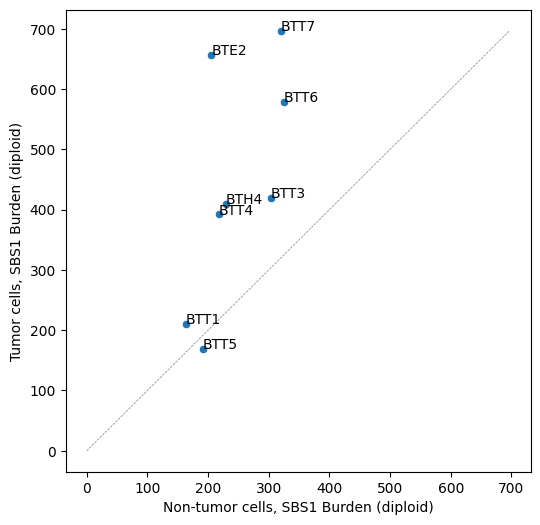

In [57]:
# Filter out rows with NaN values in the columns 'total_burden_SBS1_normal' and 'total_burden_SBS1_tumor'
tumor_normal_median_sbs1_burden_sel = tumor_normal_median_sbs1_burden.dropna(subset=['normal_burden_diploid_corr_SBS1_merged_normal', 
                                                                                 'tumor_burden_diploid_corr_SBS1_merged_normal'])

mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6, 6))  # Width x Height in inches

sns.scatterplot(
    x='normal_burden_diploid_corr_SBS1_merged_normal',
    y='tumor_burden_diploid_corr_SBS1_merged_normal',
    data=tumor_normal_median_sbs1_burden_sel
)

# Label data points
for i in range(tumor_normal_median_sbs1_burden_sel.shape[0]):
    plt.text(
         tumor_normal_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        tumor_normal_median_sbs1_burden_sel['tumor_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        tumor_normal_median_sbs1_burden_sel['sample_id_x'].iloc[i]
    )

# Add a diagonal line for reference
max_burden = max(tumor_normal_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal'].max(), \
                 tumor_normal_median_sbs1_burden_sel['tumor_burden_diploid_corr_SBS1_merged_normal'].max())
plt.plot([0, max_burden], [0, max_burden], color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Non-tumor cells, SBS1 Burden (diploid)')
plt.ylabel('Tumor cells, SBS1 Burden (diploid)')
#plt.title('SBS1 Burden between Normal and Tumor Samples, diploid')
plt.savefig(
    '/home/dg204/projects/brca_timing/data/processed/paperPlots_Apr25/Figure5B.pdf',
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata
)
plt.show()

In [58]:
(tumor_normal_median_sbs1_burden_sel['tumor_burden_diploid_corr_SBS1_merged_normal']/tumor_normal_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal']).median()


1.7843850084798327

In [59]:
tumor_normal_median_sbs1_burden_sel['tumor_burden_diploid_corr_SBS1_merged_normal']/tumor_normal_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal']

0    3.200013
1    1.788433
2    1.289784
3    1.381014
4    1.805291
5    0.886225
6    1.780337
7    2.180309
dtype: float64

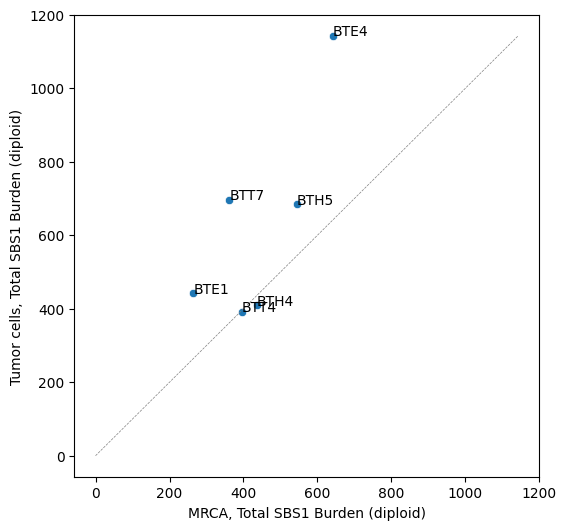

In [60]:
tumor_trunk_median_sbs1_burden=tumor_trunk_median_sbs1_burden[tumor_trunk_median_sbs1_burden['trunk_burden_diploid_corr_SBS1_merged_normal'].notna()]
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6, 6))  # Width x Height in inches

sns.scatterplot(
    y='tumor_burden_diploid_corr_SBS1_merged_normal',
    x='trunk_burden_diploid_corr_SBS1_merged_normal',
    data=tumor_trunk_median_sbs1_burden
)

# Label data points
for i in range(tumor_trunk_median_sbs1_burden.shape[0]):
    plt.text(
         tumor_trunk_median_sbs1_burden['trunk_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        tumor_trunk_median_sbs1_burden['tumor_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        tumor_trunk_median_sbs1_burden['sample_id_x'].iloc[i]
    )

# Add a diagonal line for reference
max_burden = max(tumor_trunk_median_sbs1_burden['tumor_burden_diploid_corr_SBS1_merged_normal'].max(), tumor_trunk_median_sbs1_burden['trunk_burden_diploid_corr_SBS1_merged_normal'].max())
plt.plot([0, max_burden], [0, max_burden], color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Tumor cells, Total SBS1 Burden (diploid)')
plt.xlabel('MRCA, Total SBS1 Burden (diploid)')
plt.savefig(
    '/home/dg204/projects/brca_timing/data/processed/paperPlots_Apr25/Figure5C.pdf',
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata
)
plt.show()

In [67]:
(tumor_trunk_median_sbs1_burden['tumor_burden_diploid_corr_SBS1_merged_normal'] - tumor_trunk_median_sbs1_burden['trunk_burden_diploid_corr_SBS1_merged_normal']).median()

159.556561065744

In [61]:
tumor_trunk_median_sbs1_burden

,sample_id_x,tumor_burden_diploid_corr_SBS1_merged_normal,tumor_burden_diploid_corr,trunk_burden_diploid_corr_SBS1_merged_normal,trunk_burden_diploid_corr
0,BTE1,442.067640,5074.709549,264.468830,3112.183968
2,BTE4,1142.866599,12061.255703,641.526880,7513.361373
8,BTH4,409.381675,24370.921415,435.977229,12918.301085
9,BTH5,684.981878,6732.274720,543.467566,4499.888292
15,BTT4,391.926609,8082.908139,396.212045,6013.698493
18,BTT7,696.773093,15332.180322,361.460887,10741.962360


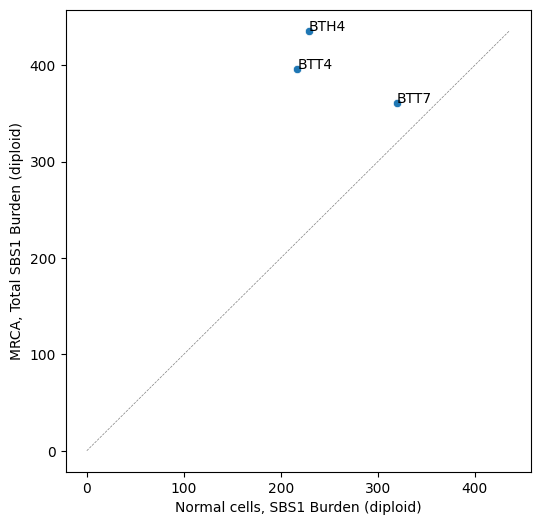

In [62]:
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6, 6))  # Width x Height in inches

sns.scatterplot(
    x='normal_burden_diploid_corr_SBS1_merged_normal',
    y='trunk_burden_diploid_corr_SBS1_merged_normal',
    data=normal_trunk_median_sbs1_burden_sel
)

for i in range(normal_trunk_median_sbs1_burden_sel.shape[0]):
    plt.text(
         normal_trunk_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        normal_trunk_median_sbs1_burden_sel['trunk_burden_diploid_corr_SBS1_merged_normal'].iloc[i],
        normal_trunk_median_sbs1_burden_sel['sample_id_x'].iloc[i]
    )

max_burden = max(normal_trunk_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal'].max(), 
                 normal_trunk_median_sbs1_burden_sel['trunk_burden_diploid_corr_SBS1_merged_normal'].max())
plt.plot([0, max_burden], [0, max_burden], color='gray', linestyle='--', linewidth=0.5)

plt.xlabel('Normal cells, SBS1 Burden (diploid)')
plt.ylabel('MRCA, Total SBS1 Burden (diploid)')
plt.savefig(
    '/home/dg204/projects/brca_timing/data/processed/paperPlots_Apr25/Figure5D.pdf',
    format='pdf',
    dpi=300,                # High resolution
    bbox_inches='tight',    # Trim whitespace
    metadata={'Creator': 'Matplotlib'}  # Metadata
)
plt.show()

In [63]:
normal_trunk_median_sbs1_burden_sel

,sample_id_x,normal_burden_diploid_corr_SBS1_merged_normal,normal_burden_diploid_corr,trunk_burden_diploid_corr_SBS1_merged_normal,trunk_burden_diploid_corr
1,BTH4,228.905281,2202.660794,435.977229,12918.301085
4,BTT4,217.098850,1854.534220,396.212045,6013.698493
7,BTT7,319.575451,2476.056143,361.460887,10741.962360


In [64]:
normal_trunk_median_sbs1_burden_sel['trunk_burden_diploid_corr_SBS1_merged_normal']/normal_trunk_median_sbs1_burden_sel['normal_burden_diploid_corr_SBS1_merged_normal']

1    1.904618
4    1.825031
7    1.131066
dtype: float64

/home/dg204/jupytervenv3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Text(0, 0.5, 'our estimate of trunk mutational burden (median across cells)')

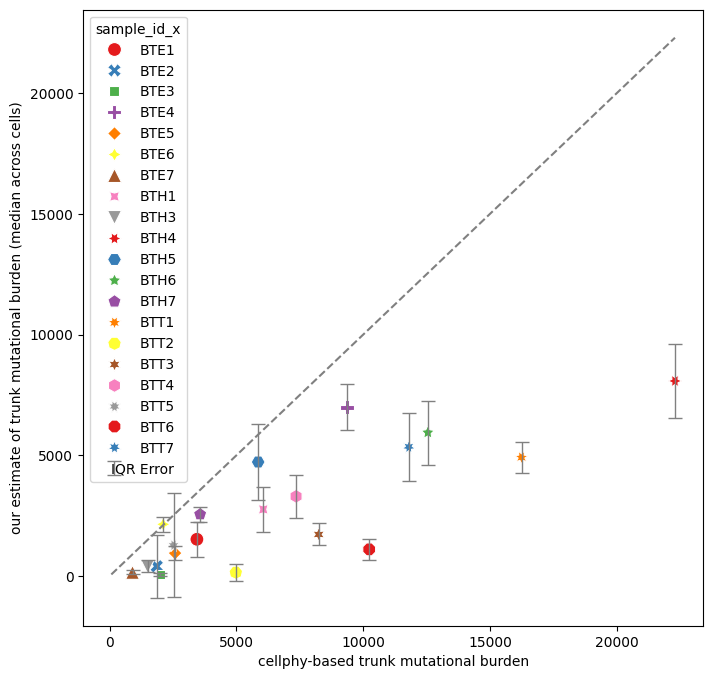

In [65]:
trunk_burden_ours = merged_cell_data.groupby('sample_id').agg({
    'total_trunk_burden_corr': [  # Calculate both median and IQR
        'median', 
        lambda x: np.nanpercentile(x, 75) - np.nanpercentile(x, 25)  # IQR = Q3 - Q1
    ],
    'trunk_bulk_total_burden_corr': [  # Calculate both median and IQR
        'median', 
        lambda x: np.nanpercentile(x, 75) - np.nanpercentile(x, 25)  # IQR = Q3 - Q1
    ]
}).reset_index()


# Rename columns for clarity
trunk_burden_ours.columns = ['sample_id', 'trunk_total_burden_median', 'trunk_total_burden_IQR', 'trunk_bulk_total_burden_median', 'trunk_bulk_total_burden_IQR']

mean_median_mrca_burden_m = pd.merge(mean_median_mrca_burden, trunk_burden_ours, left_index=True, right_on='sample_id')

plt.figure(figsize=(8, 8))

plt.errorbar(
    mean_median_mrca_burden_m['median_mrca_burden'], 
    mean_median_mrca_burden_m['trunk_total_burden_median'], 
    yerr=mean_median_mrca_burden_m['trunk_total_burden_IQR'], 
    fmt='none', 
    capsize=5, 
    capthick=1, 
    elinewidth=1, 
    ecolor='gray',  # Color of error bars
    label='IQR Error',
)



sns.scatterplot(
    data=mean_median_mrca_burden_m, 
    x='median_mrca_burden', 
    y='trunk_total_burden_median', 
    hue='sample_id_x', 
    style='sample_id_x',
    palette='Set1', 
    s=100  # Adjust marker size
)


min_val = min(mean_median_mrca_burden_m['median_mrca_burden'].min(), mean_median_mrca_burden_m['trunk_total_burden_median'].min())
max_val = max(mean_median_mrca_burden_m['median_mrca_burden'].max(), mean_median_mrca_burden_m['trunk_total_burden_median'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="gray", label="y = x")
plt.xlabel('cellphy-based trunk mutational burden')
plt.ylabel('our estimate of trunk mutational burden (median across cells)')